# Robust yield prediction of various farm processing units 
A new fast food chain is seeing rapid expansion over the past couple of years. They  are now trying to optimize their supply chain to ensure that there are no shortages  of  ingredients.  For this, they’ve tasked their data science team to come up with a  model that could predict the output of each food processing farm over the next  few years. These predictions could further increase the efficiency of their current  supply chain management systems. 

###In this competition you are expected to build a machine learning model(s) that could predict the output of the food processing farms for the next year.  

##About Data: 
####train_data:  
○ date: ​The timestamp at which the yield of the food processing farm  was 
measured  
○ farm_id: ​The farm identifier that recognizes the farm food processing  plant  
○ ingredient_type: ​The type of ingredient being produced  
○ yield: ​The yield of the plant in tons

####farm_data:  
○ farm_id: ​The farm identifier that recognizes the farm food processing  plant  
○ founding_year: ​They year when the operations commenced on the  farm and food processing plant.   
○ num_processing_plants: ​The number of processing plants present  on the farm  ○ farm_area: ​The area of the farm in square meters  
○ farming_company: ​The company that owns the farms  
○ deidentified_location: ​The location at which the farm is present  

####train_weather:  
○ For each location where the farms are present, the weather data is also  provided by timestamp  

###Evaluation Metric:  
The evaluation metric used for this course would be the ​Root Mean Squared Error  (​RMSE​)  






In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!pip install category_encoders

In [0]:
import pandas as pd
from category_encoders import OrdinalEncoder
import re
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter 
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
from itertools import groupby 
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.model_selection import train_test_split
import seaborn as sns

from mlxtend.plotting import plot_learning_curves

from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [0]:
def get_heatmap(data):
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(data.corr(),linewidths=0.1,cmap='viridis',annot=True,ax=ax,annot_kws={"size": 12})
    plt.show()

def get_dist_plot(data,col):
    sns.distplot(data[col])
    plt.show()

def get_NaN_info(data):
    return pd.DataFrame(data.dtypes,columns=['Type']).merge(pd.DataFrame(data.isnull().sum(),columns=['Total Cnt of NaN']).merge(pd.DataFrame(data.isnull().sum()/len(data)*100,columns=['Total % of NaN']),left_index=True,right_index=True),left_index=True,right_index=True).sort_values('Total % of NaN',ascending=False)

def inspect_data(data):
    return pd.DataFrame({"Data Type":data.dtypes,"No of Levels":data.apply(lambda x: x.nunique(),axis=0),"% of Unique Levels":data.apply(lambda x: x.nunique()/len(x)*100,axis=0), "Levels":data.apply(lambda x: str(x.unique()),axis=0)}).sort_values("% of Unique Levels", ascending=False)

def get_levels_NaNs_combined_info(data,cnt):
    return (inspect_data(data[get_NaN_info(data).head(cnt).index]).sort_index()).merge((get_NaN_info(data).head(cnt)).iloc[:,[1,2]],left_index=True,right_index=True)

def my_reset_index(df):
    index_df = df.index.to_frame(index=False)
    df = df.reset_index(drop=True)
    return pd.merge(index_df, df, left_index=True, right_index=True)

def memory_usage(df):
    return(round(df.memory_usage(deep=True).sum() / 1024 ** 2, 2))

def get_dict_list(list_inp,idx):
    return dict((k, [v[1:idx] for v in itr]) for k, itr in groupby( 
                                list_inp, itemgetter(0))) 

###Reading the train data

In [0]:
farm_data=pd.read_csv('/content/drive/My Drive/farm_data.csv')
train_weather=pd.read_csv('/content/drive/My Drive/train_weather.csv')
train_data=pd.read_csv('/content/drive/My Drive/train_data.csv')

###Calculating the size of the files

In [0]:
print('Memory used by farm_data:', memory_usage(farm_data), 'MB')
print('Memory used by train_weather:', memory_usage(train_weather), 'MB')
print('Memory used by train_data:', memory_usage(train_data), 'MB')

Memory used by farm_data: 0.32 MB
Memory used by train_weather: 26.9 MB
Memory used by train_data: 4091.07 MB


###Viewing the min and max values of all the numeric columns in all the dataframes

In [0]:
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(farm_data.select_dtypes(include=[np.float64]).min(),columns=['Farm_Min']),\
pd.DataFrame(farm_data.select_dtypes(include=[np.float64]).max(),columns=['Farm_Max'])],axis=1))
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(train_weather.select_dtypes(include=[np.float64]).min(),columns=['Trn_Weather_Min']),\
pd.DataFrame(train_weather.select_dtypes(include=[np.float64]).max(),columns=['Trn_Weather_Max'])],axis=1))
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(train_data.select_dtypes(include=[np.float64]).min(),columns=['Trn_data_Min']),\
pd.DataFrame(train_data.select_dtypes(include=[np.float64]).max(),columns=['Trn_data_Max'])],axis=1))
print('-------------------------------------------------------')

-------------------------------------------------------
                               Farm_Min   Farm_Max
operations_commencing_year  1900.000000   2017.000
num_processing_plants          5.000000     30.000
farm_area                     26.291549  81290.125
-------------------------------------------------------
                    Trn_Weather_Min  Trn_Weather_Max
temp_obs                      -28.9             47.2
cloudiness                      0.0              9.0
wind_direction                  0.0            360.0
dew_temp                      -35.0             26.1
pressure_sea_level            968.2           1045.5
precipitation                  -1.0            343.0
wind_speed                      0.0             19.0
-------------------------------------------------------
       Trn_data_Min  Trn_data_Max
yield           0.0    21904700.0
-------------------------------------------------------


###Type casting the variables to lower types for the pupose of memory management

In [0]:
train_data3=train_data.copy()

train_data3.date =  pd.to_datetime(train_data3.date, infer_datetime_format=True)

train_data3.farm_id=train_data3.farm_id.astype('category')
train_data3.ingredient_type=train_data3.ingredient_type.astype('category')
train_data3['yield']=train_data3['yield'].astype(np.float32)

In [0]:
train_weather3=train_weather.copy()
train_weather3.timestamp =  pd.to_datetime(train_weather3.timestamp, infer_datetime_format=True)

train_weather3.deidentified_location = train_weather3.deidentified_location.astype('category')

In [0]:
farm_data3=farm_data.copy()
farm_data3.deidentified_location = farm_data3.deidentified_location.astype('category')
farm_data3.farm_id = farm_data3.farm_id.astype('category')
farm_data3.farming_company = farm_data3.farming_company.astype('category')

In [0]:
train_weather3['temp_obs']=train_weather3['temp_obs'].astype(np.float16)
train_weather3['cloudiness']=train_weather3['cloudiness'].astype(np.float16)
train_weather3['wind_direction']=train_weather3['wind_direction'].astype(np.float16)
train_weather3['dew_temp']=train_weather3['dew_temp'].astype(np.float16)
train_weather3['pressure_sea_level']=train_weather3['pressure_sea_level'].astype(np.float16)
train_weather3['precipitation']=train_weather3['precipitation'].astype(np.float16)
train_weather3['wind_speed']=train_weather3['wind_speed'].astype(np.float16)

In [0]:
farm_data3['operations_commencing_year']=farm_data3['operations_commencing_year'].astype(np.float16)
farm_data3['num_processing_plants']=farm_data3['num_processing_plants'].astype(np.float16)
farm_data3['farm_area']=farm_data3['farm_area'].astype(np.float32)

###Viewing the file sizes after type casting

In [0]:
print('Memory used by farm_data:', memory_usage(farm_data3), 'MB')
print('Memory used by train_weather:', memory_usage(train_weather3), 'MB')
print('Memory used by train_data:', memory_usage(train_data3), 'MB')

Memory used by farm_data: 0.15 MB
Memory used by train_weather: 3.07 MB
Memory used by train_data: 289.32 MB


###Verifying if there is any truncation of the variables data, after type casting to lower data types

In [0]:
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(farm_data3.select_dtypes(include=[np.float16,np.float32]).min(),columns=['Farm_Min']),\
pd.DataFrame(farm_data3.select_dtypes(include=[np.float16,np.float32]).max(),columns=['Farm_Max'])],axis=1))
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(train_weather3.select_dtypes(include=[np.float16,np.float32]).min(),columns=['Trn_Weather_Min']),\
pd.DataFrame(train_weather3.select_dtypes(include=[np.float16,np.float32]).max(),columns=['Trn_Weather_Max'])],axis=1))
print('-------------------------------------------------------')
print(pd.concat([pd.DataFrame(train_data3.select_dtypes(include=[np.float16,np.float32]).min(),columns=['Trn_data_Min']),\
pd.DataFrame(train_data3.select_dtypes(include=[np.float16,np.float32]).max(),columns=['Trn_data_Max'])],axis=1))
print('-------------------------------------------------------')

-------------------------------------------------------
                              Farm_Min   Farm_Max
operations_commencing_year  1900.00000   2017.000
num_processing_plants          5.00000     30.000
farm_area                     26.29155  81290.125
-------------------------------------------------------
                    Trn_Weather_Min  Trn_Weather_Max
temp_obs                  -28.90625         47.18750
cloudiness                  0.00000          9.00000
wind_direction              0.00000        360.00000
dew_temp                  -35.00000         26.09375
pressure_sea_level        968.00000       1046.00000
precipitation              -1.00000        343.00000
wind_speed                  0.00000         19.00000
-------------------------------------------------------
       Trn_data_Min  Trn_data_Max
yield           0.0    21904700.0
-------------------------------------------------------


In [0]:
del [farm_data,train_data,train_weather]

###Checking the Total No & % of NaN values, Total No & % of unique values wrt each column in a train dataset

In [0]:
get_levels_NaNs_combined_info(train_data3,len(train_data3.columns))

Data Type  No of Levels  % of Unique Levels  \
date             datetime64[ns]          8784            0.043451   
farm_id                category          1434            0.007093   
ingredient_type        category             4            0.000020   
yield                   float32       1688175            8.350646   

                                                            Levels  \
date             ['2016-01-01T00:00:00.000000000' '2016-01-01T0...   
farm_id          [fid_110884, fid_90053, fid_17537, fid_110392,...   
ingredient_type  [ing_w, ing_z, ing_x, ing_y]\nCategories (4, o...   
yield            [   0.           53.23970032   43.00130081 ......   

                 Total Cnt of NaN  Total % of NaN  
date                            0             0.0  
farm_id                         0             0.0  
ingredient_type                 0             0.0  
yield                           0             0.0

###Viewing the statistical measures of the train dataset

In [0]:
train_data3.describe()

yield
count  2.021610e+07
mean   1.988706e+03
std    1.532159e+05
min    0.000000e+00
25%    1.830000e+01
50%    7.877500e+01
75%    2.679840e+02
max    2.190470e+07

###Checking the Total No & % of NaN values, Total No & % of unique values wrt each column in a train_weather dataset

In [0]:
get_levels_NaNs_combined_info(train_weather3,len(train_weather3.columns))

Data Type  No of Levels  % of Unique Levels  \
cloudiness                    float16            10            0.007154   
deidentified_location        category            16            0.011447   
dew_temp                      float16           522            0.373463   
precipitation                 float16           128            0.091577   
pressure_sea_level            float16           133            0.095154   
temp_obs                      float16           619            0.442861   
timestamp              datetime64[ns]          8784            6.284476   
wind_direction                float16            43            0.030764   
wind_speed                    float16            58            0.041496   

                                                                  Levels  \
cloudiness                 [ 6. nan  2.  4.  8.  0.  9.  7.  5.  3.  1.]   
deidentified_location  [location 7369, location 959, location 5489, l...   
dew_temp               [ 20.          21.09375     20.59375     19.40...   
precipitation          [ nan  -1.   0.   3.   5.   8.   2.  10.  20. ...   
pressure_sea_level     [1019.5 1020.     nan 1019.  1018.  1018.5 102...   
temp_obs               [ 25.          24.40625     22.796875    21.09...   
timestamp              ['2016-01-01T00:00:00.000000000' '2016-01-01T0...   
wind_direction         [  0.  70. 250. 210. 290. 230. 200. 180. 220. ...   
wind_speed             [ 0.          1.5         2.59960938  3.099609...   

                       Total Cnt of NaN  Total % of NaN  
cloudiness                        69173       49.489529  
deidentified_location                 0        0.000000  
dew_temp                            113        0.080845  
precipitation                     50289       35.979052  
pressure_sea_level                10618        7.596603  
temp_obs                             55        0.039350  
timestamp                             0        0.000000  
wind_direction                     6268        4.484414  
wind_speed                          304        0.217496

In [0]:
train_weather3.tail(3)

timestamp deidentified_location  temp_obs  cloudiness  \
139770 2016-12-31 21:00:00         location 5150  2.800781         NaN   
139771 2016-12-31 22:00:00         location 5150  2.199219         NaN   
139772 2016-12-31 23:00:00         location 5150  1.700195         NaN   

        wind_direction  dew_temp  pressure_sea_level  precipitation  \
139770           180.0 -7.199219              1007.5            NaN   
139771           170.0 -6.699219              1008.0            NaN   
139772           180.0 -5.601562              1008.5           -1.0   

        wind_speed  
139770    5.101562  
139771    4.601562  
139772    8.796875

###Checking if there are any dulicate rows in train_weather dataset wrt timestamp and location

In [0]:
any(train_weather3.loc[:,['timestamp','deidentified_location']].duplicated())

False

###Checking the Total No & % of NaN values, Total No & % of unique values wrt each column in a farm dataset

In [0]:
get_levels_NaNs_combined_info(farm_data3,len(farm_data3.columns))

Data Type  No of Levels  % of Unique Levels  \
deidentified_location       category            16            1.104210   
farm_area                    float32          1397           96.411318   
farm_id                     category          1434           98.964803   
farming_company             category            16            1.104210   
num_processing_plants        float16            18            1.242236   
operations_commencing_year   float16           116            8.005521   

                                                                       Levels  \
deidentified_location       [location 7369, location 959, location 5489, l...   
farm_area                   [ 690.45507812  252.69616699  499.4465332  ......   
farm_id                     [fid_110884, fid_90053, fid_17537, fid_110392,...   
farming_company             [Obery Farms, Dole Food Company, Wayne Farms, ...   
num_processing_plants       [nan  9.  8. 14. 10. 12. 11. 13. 17. 20. 15. 1...   
operations_commencing_year  [2008. 2004. 1991. 2002. 1975. 2000. 1981. 198...   

                            Total Cnt of NaN  Total % of NaN  
deidentified_location                      0        0.000000  
farm_area                                  0        0.000000  
farm_id                                    0        0.000000  
farming_company                            0        0.000000  
num_processing_plants                   1094       75.500345  
operations_commencing_year               774       53.416149

In [0]:
farm_data3.tail(3)

farm_id  operations_commencing_year  num_processing_plants  \
1446  fid_46454                      1997.0                    NaN   
1447  fid_24103                      2001.0                    NaN   
1448  fid_34139                      2001.0                    NaN   

        farm_area    farming_company deidentified_location  
1446  1046.552246    Sanderson Farms         location 5150  
1447  2766.186768  Dole Food Company         location 5150  
1448  8572.252930        Wayne Farms         location 5150

###Viewing the distribution of the farm_id and farm_area wrt farming_company and deidentified location.


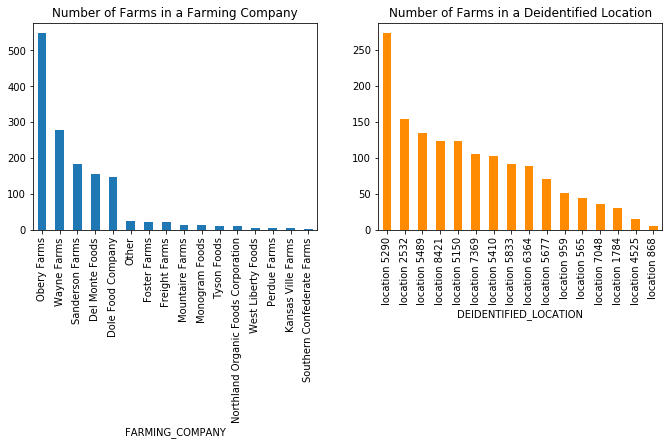

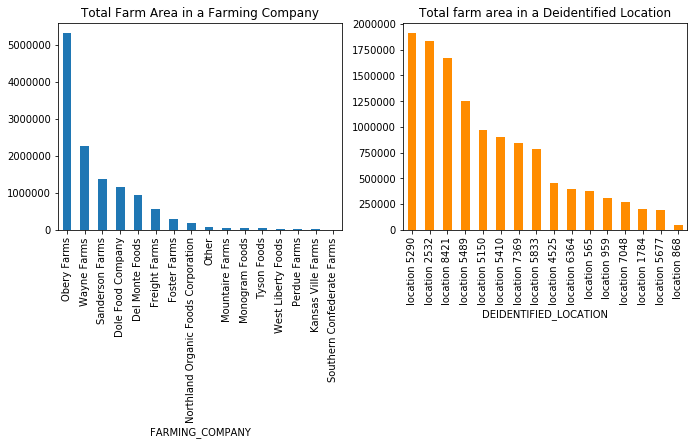

In [0]:
#
fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout(pad=3)
df=farm_data3.groupby(['farming_company'])['farm_id'].size().sort_values(ascending=False)
df.plot.bar(ax=ax[0])
ax[0].set_title('Number of Farms in a Farming Company')
ax[0].set_xlabel(str.upper('farming_company'),fontsize=10)

df=farm_data3.groupby(['deidentified_location'])['farm_id'].size().sort_values(ascending=False)
df.plot.bar(ax=ax[1],color='darkorange')
ax[1].set_title('Number of Farms in a Deidentified Location')
ax[1].set_xlabel(str.upper('deidentified_location'),fontsize=10)
plt.show()

fig,ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout(pad=3)
df=farm_data3.groupby(['farming_company'])['farm_area'].sum().sort_values(ascending=False)
df.plot.bar(ax=ax[0])
ax[0].set_title('Total Farm Area in a Farming Company')
ax[0].set_xlabel(str.upper('farming_company'),fontsize=10)


df=farm_data3.groupby(['deidentified_location'])['farm_area'].sum().sort_values(ascending=False)
df.plot.bar(ax=ax[1],color='darkorange')
ax[1].set_title('Total farm area in a Deidentified Location')
ax[1].set_xlabel(str.upper('deidentified_location'),fontsize=10)
plt.show()


###Viewing the MONTH wise trend of the train_weather parameters wrt DEIDENTIFIED LOCATION

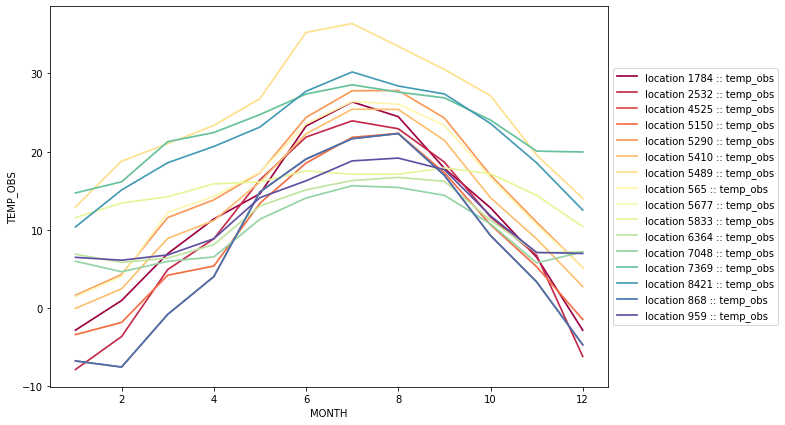

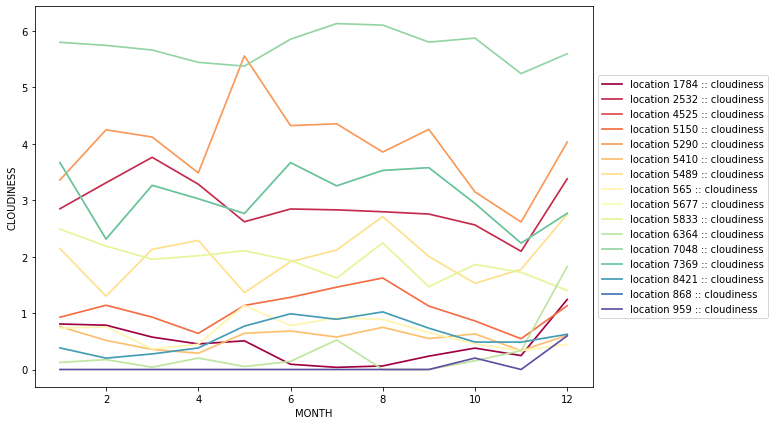

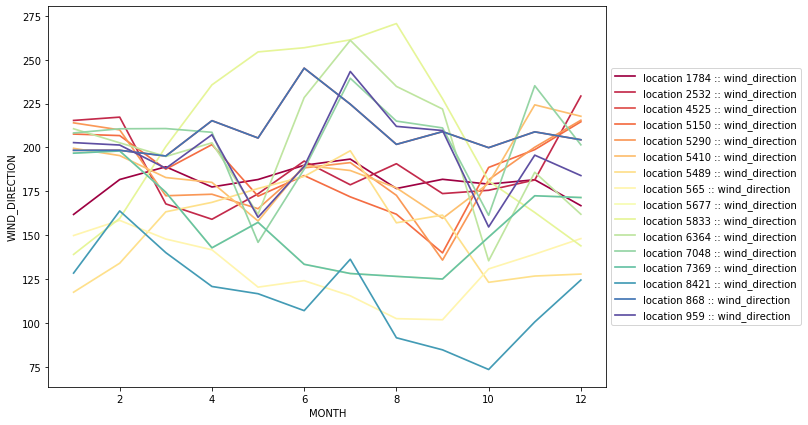

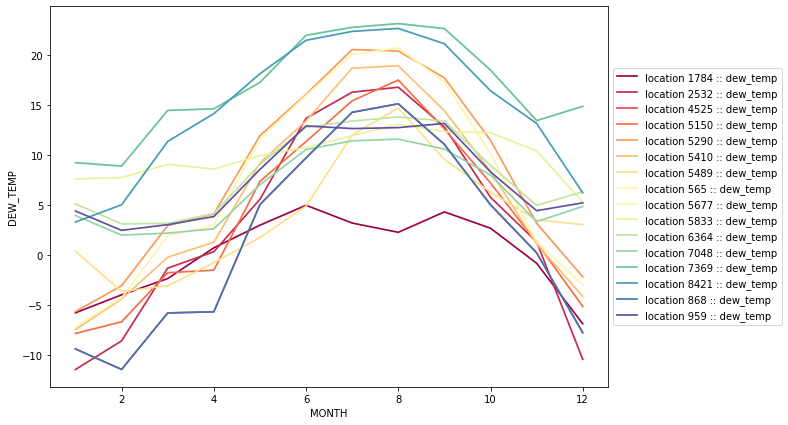

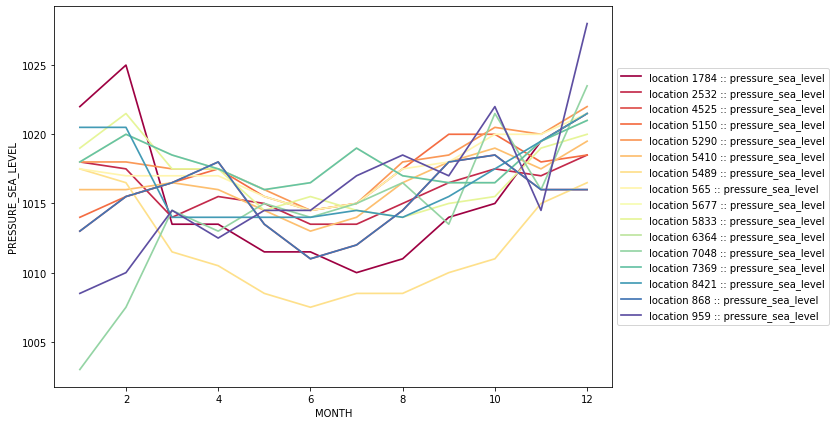

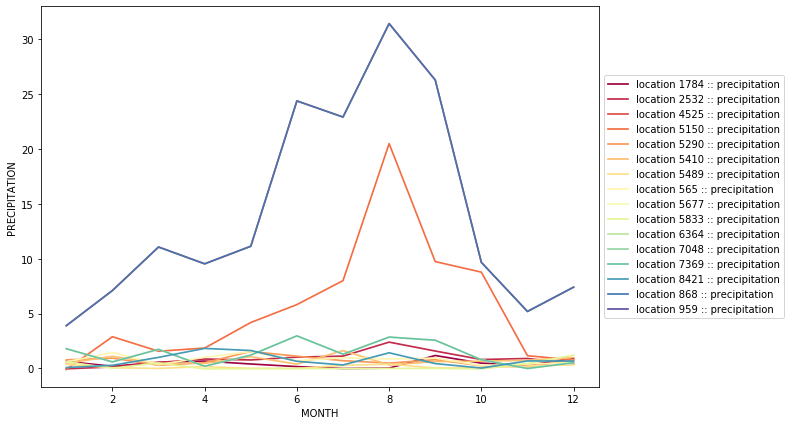

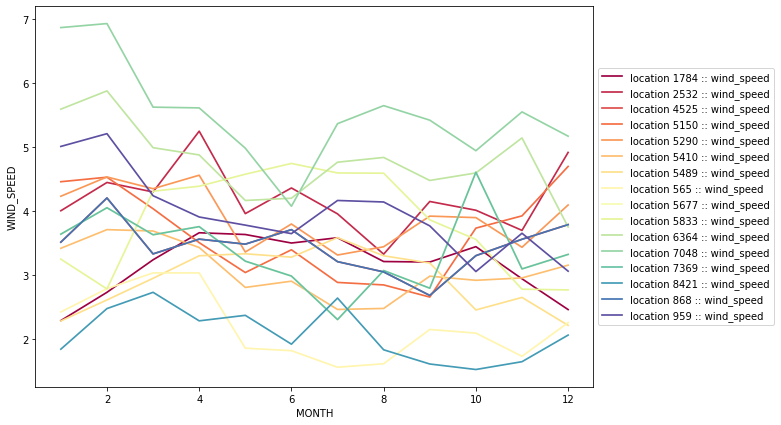

In [0]:
train_weather2=train_weather3.copy()

train_weather2['month']=pd.DatetimeIndex(train_weather2['timestamp']).month

location_list=list(np.unique(train_weather2['deidentified_location']))
trn_weather_cols=train_weather3.columns

import matplotlib.pyplot as plt
for col_indx,col in enumerate(trn_weather_cols[2:]):
    fig,ax=plt.subplots(figsize=(10,7))
    
    plt.gca().set_prop_cycle('color',plt.cm.Spectral(np.linspace(0,1,16)))
    for loc_indx,location in enumerate(location_list):
        
        temp_df=pd.DataFrame(train_weather2[train_weather2['deidentified_location']==location].groupby(['month'])[col]\
                     .mean()).rename(columns={col:location+' :: '+col})
        temp_df['month']=temp_df.index
        plt.plot('month',temp_df.columns[0],data=temp_df,linewidth=1.7)
        
    plt.xlabel('MONTH')
    plt.ylabel(str.upper(col))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plt.show()
    #break   


###Checking if there are any duplicate farm_id's in Farm dataset

In [0]:
any(farm_data3['farm_id'].duplicated())

True

###There are 15 duplicate farm_id's 

In [0]:
dup_fids=list(farm_data3[farm_data3['farm_id'].duplicated()]['farm_id'])

In [0]:
len(dup_fids)

15

###There are 2 records for each duplicate farm_id in the farm dataset

In [0]:
farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id').shape

(30, 6)

In [0]:
farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id').head()

farm_id  operations_commencing_year  num_processing_plants  \
1136  fid_122174                         NaN                    NaN   
1076  fid_122174                         NaN                    NaN   
594    fid_18990                      1964.0                   11.0   
537    fid_18990                      1959.0                    NaN   
1156   fid_26064                         NaN                    NaN   

         farm_area    farming_company deidentified_location  
1136   7411.987305        Wayne Farms         location 2532  
1076  10874.667969  Dole Food Company         location 2532  
594   16469.937500        Obery Farms         location 5833  
537    6800.499512        Obery Farms         location 5290  
1156  24153.757812        Obery Farms         location 2532

###Viewing few records of train dataset

In [0]:
train_data3.tail(3)

date    farm_id ingredient_type       yield
20216097 2016-12-31 23:00:00  fid_46454           ing_w    0.000000
20216098 2016-12-31 23:00:00  fid_24103           ing_w  159.574997
20216099 2016-12-31 23:00:00  fid_34139           ing_w    2.850000

###Checking for duplicate records in Train data based on below features

In [0]:
any(train_data3.loc[:,['farm_id','date','ingredient_type']].duplicated())

True

In [0]:
train_data3_grouped2=train_data3.groupby(['farm_id','date','ingredient_type'])['yield'].size().unstack()

###Separating the records from train dataset that are duplicate, when farm_id, date and ingredient_type are grouped

In [0]:
train_data3_grouped2=train_data3_grouped2[(train_data3_grouped2['ing_w']>1)|(train_data3_grouped2['ing_x']>1)|(train_data3_grouped2['ing_y']>1)|\
                   (train_data3_grouped2['ing_z']>1)]
train_data3_grouped2.columns=[str(x) for x in list(train_data3_grouped2.columns)]
train_data3_grouped2=my_reset_index(train_data3_grouped2)
train_data3_grouped2.head()  

farm_id                date  ing_w  ing_x  ing_y  ing_z
0  fid_122174 2016-01-01 00:00:00    2.0    1.0    1.0    NaN
1  fid_122174 2016-01-01 01:00:00    2.0    1.0    1.0    NaN
2  fid_122174 2016-01-01 02:00:00    2.0    1.0    1.0    NaN
3  fid_122174 2016-01-01 03:00:00    2.0    1.0    1.0    NaN
4  fid_122174 2016-01-01 04:00:00    2.0    1.0    1.0    NaN

###Making a list of farm_id's that are duplicate in train dataset when farm_id, date and ingredient_type are grouped

In [0]:
mul_rec_fids=list(np.unique(train_data3_grouped2['farm_id']))

###There are 15 farm_id with duplicate records

In [0]:
len(mul_rec_fids)

15

###We observe that the farm_id's that are duplicate in farm dataset and train dataset are same

In [0]:
print(np.sort(dup_fids))

['fid_122174' 'fid_18990' 'fid_26064' 'fid_29387' 'fid_40459' 'fid_53126'
 'fid_54932' 'fid_59158' 'fid_63700' 'fid_68761' 'fid_68792' 'fid_71910'
 'fid_73431' 'fid_81333' 'fid_97094']


In [0]:
print(np.sort(mul_rec_fids))

['fid_122174' 'fid_18990' 'fid_26064' 'fid_29387' 'fid_40459' 'fid_53126'
 'fid_54932' 'fid_59158' 'fid_63700' 'fid_68761' 'fid_68792' 'fid_71910'
 'fid_73431' 'fid_81333' 'fid_97094']


###Separating all the records of duplicate farm id's in train dataset

In [0]:
train_data3_dups=train_data3[train_data3['farm_id'].isin(mul_rec_fids)]

###Sorting the duplicate records dataframe 

In [0]:
train_data3_dups=train_data3_dups.sort_values(['farm_id','date','ingredient_type','yield'])

###Making a separate dataframe with the duplicate fids and merging both the farm and train data

In [0]:
train3_dups_farm3_dups_df=train_data3_dups.merge(farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id'),left_on='farm_id',right_on='farm_id')

####Viewing the crops that are present in a paricular duplicate farm_id and where the farm is located and under which farming company

In [0]:

dup_farm_loc_list=list(train3_dups_farm3_dups_df.groupby(['farm_id','deidentified_location','farming_company','ingredient_type'])['ingredient_type'].size().index)
    
res = get_dict_list(dup_farm_loc_list,4)
res2={}
res3={}

for key,values in res.items():
    res2[key]=get_dict_list(values,3)

print('---------------------------------------------------------------------------------------------') 
for k,v in res2.items():
    print(k)
    for k2,v2 in v.items():
        l=[]
        for ing in v2:
            l+=list(ing)
        l1=np.unique(l[0::2])
        l2=np.unique(l[1::2])
        #print(k,)
        print('    ',l2,'--->',k2,'--->',l1)
    print('---------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------
fid_122174
     ['ing_w' 'ing_x' 'ing_y'] ---> location 2532 ---> ['Dole Food Company' 'Wayne Farms']
---------------------------------------------------------------------------------------------
fid_18990
     ['ing_w'] ---> location 5290 ---> ['Obery Farms']
     ['ing_w'] ---> location 5833 ---> ['Obery Farms']
---------------------------------------------------------------------------------------------
fid_26064
     ['ing_w' 'ing_x' 'ing_y'] ---> location 2532 ---> ['Obery Farms']
     ['ing_w' 'ing_x' 'ing_y'] ---> location 5290 ---> ['Del Monte Foods']
---------------------------------------------------------------------------------------------
fid_29387
     ['ing_w'] ---> location 5833 ---> ['Obery Farms']
     ['ing_w'] ---> location 7048 ---> ['Wayne Farms']
---------------------------------------------------------------------------------------------
fid_40459
     ['ing_w'] ---> lo

###Viewing the records of the duplicate farm_id 

In [0]:

for fid in mul_rec_fids: 
    print('=========================================================================================')
    print(train_data3_dups[(train_data3_dups['farm_id']==fid)&~(train_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].tail(10))
    print('-----------------------------------------------------------------------------------------')
    print(train_data3_dups[(train_data3_dups['farm_id']==fid)&(train_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].tail(10))
    print('=========================================================================================')

                        date     farm_id ingredient_type        yield
20208173 2016-12-31 20:00:00  fid_122174           ing_y  1304.689941
20210653 2016-12-31 21:00:00  fid_122174           ing_w    39.358002
20210654 2016-12-31 21:00:00  fid_122174           ing_x     3.248700
20210538 2016-12-31 21:00:00  fid_122174           ing_y  1312.500000
20213020 2016-12-31 22:00:00  fid_122174           ing_w    39.189999
20213021 2016-12-31 22:00:00  fid_122174           ing_x     2.332400
20212905 2016-12-31 22:00:00  fid_122174           ing_y  1265.619995
20215385 2016-12-31 23:00:00  fid_122174           ing_w    38.299000
20215386 2016-12-31 23:00:00  fid_122174           ing_x     3.332000
20215270 2016-12-31 23:00:00  fid_122174           ing_y  1277.339966
-----------------------------------------------------------------------------------------
                        date     farm_id ingredient_type      yield
20193988 2016-12-31 14:00:00  fid_122174           ing_w  62.875000
2019

####Viewing the farm data of the duplicate farm id's in farm dataset

In [0]:
farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values(['farm_id','farm_area']).tail(10)

farm_id  operations_commencing_year  num_processing_plants  \
822   fid_68792                         NaN                    5.0   
376   fid_68792                      1942.0                    NaN   
679   fid_71910                      1976.0                    7.0   
736   fid_71910                      1976.0                    7.0   
287   fid_73431                      1956.0                    NaN   
1181  fid_73431                         NaN                    NaN   
325   fid_81333                      1959.0                    NaN   
649   fid_81333                      1996.0                   14.0   
395   fid_97094                      1912.0                    NaN   
1353  fid_97094                         NaN                    NaN   

         farm_area             farming_company deidentified_location  
822      34.002499             Sanderson Farms         location 5677  
376   54436.976562                 Wayne Farms         location 5290  
679    4031.990234             Del Monte Foods         location 6364  
736    8794.011719                 Obery Farms         location 6364  
287    3132.038818                 Wayne Farms         location 5489  
1181   5630.479004                 Obery Farms         location 2532  
325    5499.857422                 Obery Farms         location 5290  
649   10787.989258                 Obery Farms         location 5833  
395     829.159302             Del Monte Foods         location 5290  
1353   2062.539551  Southern Confederate Farms         location 5150

In [0]:
farm_data33=farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id')

####Based on the above analysis mapped the inredients to the specific record of the duplicate farm id in farm dataset

In [0]:
farm_data33['ings']=['ing_w ing_x','dups_ing_w ing_y','dups_ing_w','ing_w','dups_ing_w ing_y ing_x','ing_w','dups_ing_w','ing_w',\
'dups_ing_w','ing_w','ing_w ing_x','dups_ing_w','ing_w','dups_ing_w','ing_w','dups_ing_w','ing_w ing_x ing_y',\
'dups_ing_w dups_ing_x ing_z','ing_w ing_x ing_z','dups_ing_w','dups_ing_w','ing_w','dups_ing_w','ing_w',\
'ing_w ing_x ing_z','dups_ing_w','dups_ing_w','ing_w','ing_w ing_x','dups_ing_w']

###Viewing the farm dataset after mapping the ingredients

In [0]:
farm_data333=farm_data33.sort_values(['farm_id','ings'],ascending=False)
farm_data333.head(10)

farm_id  operations_commencing_year  num_processing_plants  \
395   fid_97094                      1912.0                    NaN   
1353  fid_97094                         NaN                    NaN   
325   fid_81333                      1959.0                    NaN   
649   fid_81333                      1996.0                   14.0   
287   fid_73431                      1956.0                    NaN   
1181  fid_73431                         NaN                    NaN   
679   fid_71910                      1976.0                    7.0   
736   fid_71910                      1976.0                    7.0   
822   fid_68792                         NaN                    5.0   
376   fid_68792                      1942.0                    NaN   

         farm_area             farming_company deidentified_location  \
395     829.159302             Del Monte Foods         location 5290   
1353   2062.539551  Southern Confederate Farms         location 5150   
325    5499.857422                 Obery Farms         location 5290   
649   10787.989258                 Obery Farms         location 5833   
287    3132.038818                 Wayne Farms         location 5489   
1181   5630.479004                 Obery Farms         location 2532   
679    4031.990234             Del Monte Foods         location 6364   
736    8794.011719                 Obery Farms         location 6364   
822      34.002499             Sanderson Farms         location 5677   
376   54436.976562                 Wayne Farms         location 5290   

                   ings  
395         ing_w ing_x  
1353         dups_ing_w  
325               ing_w  
649          dups_ing_w  
287   ing_w ing_x ing_z  
1181         dups_ing_w  
679               ing_w  
736          dups_ing_w  
822               ing_w  
376          dups_ing_w

###Using the above mapping information, now we are creating a dictionary for farm id with indexes of duplicate records, non-duplicate records, non-duplicate but need to be mapped to the farm id record of the duplicate record, which we are doing based on the farm area. 
### Assumption: Greater the farm area, better is the yield output

In [0]:

indexes2={}
for fid in mul_rec_fids:
    # taking row indexes of farms data from train dataset, all indexes excluding the duplicate record indexes
    indexes2['nondup-'+fid]=list(train_data3_dups[(train_data3_dups['farm_id']==fid)&~(train_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].index)
    
    # taking row indexes of farms data from train dataset, only the duplicate record indexes
    indexes2['dup-'+fid]=list(train_data3_dups[(train_data3_dups['farm_id']==fid)&(train_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].index)
    
    # from the above farm_data333 dataframe taking the non-dups_ings information for a particular farm id that are along with the dups_ings
    # If there are no non-dups_ings for a farm id, we get empty list. Example: for fid_97094 we get empty, for fid_26064 we get
    # ['ing_y', 'ing_x'] as we have dups_ings i.e dups_ing_w along with them
    dups_loc_non_dups=[i for i in list(farm_data333[farm_data333['farm_id']==fid].tail(1)['ings'].values)[0].split() if 'dups_' not in i]
    
    # taking row indexes of farms data from train dataset, all indexes of the non-dups_ings extracted above specific to 
    # a particular farm 
    if len(dups_loc_non_dups):
        indexes2['dupslocnondup-'+fid]=list(train_data3_dups[(train_data3_dups['farm_id']==fid)&~(train_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())&(train_data3_dups['ingredient_type'].isin(dups_loc_non_dups))].index)


In [0]:
indexes2.keys()

dict_keys(['nondup-fid_122174', 'dup-fid_122174', 'dupslocnondup-fid_122174', 'nondup-fid_18990', 'dup-fid_18990', 'nondup-fid_26064', 'dup-fid_26064', 'dupslocnondup-fid_26064', 'nondup-fid_29387', 'dup-fid_29387', 'nondup-fid_40459', 'dup-fid_40459', 'nondup-fid_53126', 'dup-fid_53126', 'nondup-fid_54932', 'dup-fid_54932', 'nondup-fid_59158', 'dup-fid_59158', 'nondup-fid_63700', 'dup-fid_63700', 'dupslocnondup-fid_63700', 'nondup-fid_68761', 'dup-fid_68761', 'nondup-fid_68792', 'dup-fid_68792', 'nondup-fid_71910', 'dup-fid_71910', 'nondup-fid_73431', 'dup-fid_73431', 'nondup-fid_81333', 'dup-fid_81333', 'nondup-fid_97094', 'dup-fid_97094'])

In [0]:
train_data33=train_data3.copy()

###Mapping the corresponding deidentification location and farming company to the duplicate farm id records in the train data using the indexes gathered in earlier step, so that they no more be duplicate

In [0]:
#element is a variable to control the below flow of code
element=1

for key,idx_value in indexes2.items():
    #print(key)
    fid=key.split('-')[1]
    
    if (key.split('-')[0]!='dupslocnondup')&(element==3):
        # if there are no dupslocnondup- for a file id making element = 1 to control the below execution flow
        element=1
        
    if(element==1):
        # this code is for nondup- indexes
        
        # Extracting farming_company and deidentified_location particular a farm_id
        farm_comp=farm_data333[farm_data333['farm_id']==fid].head(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].head(1)['deidentified_location'].values[0]
        
        train_data33.loc[(train_data33.index.isin(idx_value)),'farming_company']=farm_comp                      
        
        train_data33.loc[(train_data33.index.isin(idx_value)),'deidentified_location']=deid_loc
                            
        prev_idx_value=idx_value
        
        element=2
        
    elif element==2:
        # this code is for dup- indexes
        
        farm_comp=farm_data333[farm_data333['farm_id']==fid].tail(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].tail(1)['deidentified_location'].values[0]
        

        train_data33.loc[(train_data33.index.isin(idx_value)),'farming_company']=farm_comp
                 
        train_data33.loc[(train_data33.index.isin(idx_value)),'deidentified_location']=deid_loc

        element=3
    else:
        # this code is for dupslocnondup- indexes
        
        farm_comp=farm_data333[farm_data333['farm_id']==fid].tail(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].tail(1)['deidentified_location'].values[0]
      
        train_data33.loc[(train_data33.index.isin(idx_value)),'farming_company']=farm_comp
             
        train_data33.loc[(train_data33.index.isin(idx_value)),'deidentified_location']=deid_loc
        
        element=1
    


###Type casting the newly created columns of train dataset

In [0]:
train_data33.farming_company=train_data33.farming_company.astype('category')
train_data33.deidentified_location=train_data33.deidentified_location.astype('category')

In [0]:
train_data33.shape

(20216100, 6)

####Viewing the data of the duplicate fid records

In [0]:

train_data33[train_data33['farm_id'].isin(dup_fids)].tail()

date    farm_id ingredient_type      yield  \
20215790 2016-12-31 23:00:00  fid_63700           ing_z  89.849701   
20215903 2016-12-31 23:00:00  fid_59158           ing_w   6.900000   
20215904 2016-12-31 23:00:00  fid_59158           ing_y   0.000000   
20215920 2016-12-31 23:00:00  fid_97094           ing_w   2.400000   
20215921 2016-12-31 23:00:00  fid_97094           ing_x   2.509100   

          farming_company deidentified_location  
20215790      Obery Farms         location 8421  
20215903      Obery Farms         location 5150  
20215904      Obery Farms         location 5150  
20215920  Del Monte Foods         location 5290  
20215921  Del Monte Foods         location 5290

####Viewing the data of the NON-duplicate fid records

In [0]:
train_data33[~(train_data33['farm_id'].isin(dup_fids))].tail()

date    farm_id ingredient_type       yield  \
20216095 2016-12-31 23:00:00  fid_41664           ing_w    8.750000   
20216096 2016-12-31 23:00:00  fid_14529           ing_w    4.825000   
20216097 2016-12-31 23:00:00  fid_46454           ing_w    0.000000   
20216098 2016-12-31 23:00:00  fid_24103           ing_w  159.574997   
20216099 2016-12-31 23:00:00  fid_34139           ing_w    2.850000   

         farming_company deidentified_location  
20216095             NaN                   NaN  
20216096             NaN                   NaN  
20216097             NaN                   NaN  
20216098             NaN                   NaN  
20216099             NaN                   NaN

###Now we need to map the deidentified location and farming company to the train data for NON-duplicate fids
####Taking all the fids records that are not duplicates


In [0]:

train_data33_nondups=train_data33[~(train_data33['farm_id'].isin(mul_rec_fids))]

In [0]:
train_data33_nondups.shape

(19829301, 6)

###Merging NON-duplicate fid train dataset with farm dataset

In [0]:
train_data33_nondups_farm3_df=train_data33_nondups.merge(farm_data3,left_on=['farm_id'],right_on=['farm_id'])

In [0]:
train_data33_nondups_farm3_df=train_data33_nondups_farm3_df.loc[:,['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company_y',\
                                                                   'deidentified_location_y']]

In [0]:
train_data33_nondups_farm3_df.columns=['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company','deidentified_location']

###Creating the complete train dataset by concatenating duplicate farm id's and NON-duplicate farm id datasets containing deidentified location and farming company information

In [0]:
train_data_final=pd.concat([train_data33_nondups_farm3_df,train_data33[train_data33['farm_id'].isin(mul_rec_fids)]],axis=0)

###Shape of the dataset after conatenating

In [0]:
train_data_final.shape

(20216100, 6)

In [0]:
train_data_final=train_data_final.sort_values(['farm_id','date','ingredient_type','yield'])

In [0]:
del [train3_dups_farm3_dups_df,train_data33_nondups,train_data3_grouped2,train_data33_nondups_farm3_df,] 
del[train_data3_scaled]
del [train_data3_dups,train_data3,train_data33]

In [0]:
train_data_final.farming_company=train_data_final.farming_company.astype('category')
train_data_final.deidentified_location=train_data_final.deidentified_location.astype('category')

In [0]:
train_data_final.head(3)

date     farm_id ingredient_type      yield  \
4108810 2016-01-01 00:00:00  fid_100053           ing_w  37.040001   
4108811 2016-01-01 01:00:00  fid_100053           ing_w  37.119999   
4108812 2016-01-01 02:00:00  fid_100053           ing_w  37.779999   

         farming_company deidentified_location  
4108810  Del Monte Foods         location 5290  
4108811  Del Monte Foods         location 5290  
4108812  Del Monte Foods         location 5290

###Merging Farm data and weather data on deidentified location

In [0]:

farm3_weather3_df=farm_data3.merge(train_weather3,left_on=['deidentified_location'],right_on=['deidentified_location'])

In [0]:
farm3_weather3_df.shape

(12676166, 14)

In [0]:
farm3_weather3_df.head(3)

farm_id  operations_commencing_year  num_processing_plants   farm_area  \
0  fid_110884                      2008.0                    NaN  690.455078   
1  fid_110884                      2008.0                    NaN  690.455078   
2  fid_110884                      2008.0                    NaN  690.455078   

  farming_company deidentified_location           timestamp   temp_obs  \
0     Obery Farms         location 7369 2016-01-01 00:00:00  25.000000   
1     Obery Farms         location 7369 2016-01-01 01:00:00  24.406250   
2     Obery Farms         location 7369 2016-01-01 02:00:00  22.796875   

   cloudiness  wind_direction  dew_temp  pressure_sea_level  precipitation  \
0         6.0             0.0  20.00000              1019.5            NaN   
1         NaN            70.0  21.09375              1020.0           -1.0   
2         2.0             0.0  21.09375              1020.0            0.0   

   wind_speed  
0         0.0  
1         1.5  
2         0.0

###Number of timestamp records for each location present in train_weather data

In [0]:
pd.DataFrame(train_weather3.groupby(['deidentified_location']).size()).head(3)

0
deidentified_location      
location 1784          8782
location 2532          8783
location 4525          8614

###Number of timestamp records present for each ingredient type in a location under a farming company

In [0]:

pd.DataFrame(train_data_final.groupby(['deidentified_location','ingredient_type','farming_company','farm_id']).size()).head()

0
deidentified_location ingredient_type farming_company   farm_id         
location 1784         ing_w           Dole Food Company fid_113732  8773
                                                        fid_116101  8769
                                                        fid_67562   8763
                                      Obery Farms       fid_107641  8745
                                                        fid_116743  8771

###Performing a left join between train_data_final and farm3_weather3_df

In [0]:

final_merged_df=train_data_final.merge(farm3_weather3_df,how='left',left_on=['farm_id','date','farming_company','deidentified_location'],\
                                      right_on=['farm_id','timestamp','farming_company','deidentified_location'])

###Shape of the final dataset after merging train, farm and weather datasets

In [0]:
final_merged_df.shape

(20216100, 17)

###Feature Engineering

In [0]:
final_merged_df['day']=pd.DatetimeIndex(final_merged_df['date']).day
final_merged_df['day']=final_merged_df['day'].astype(np.uint8)
final_merged_df['month']=pd.DatetimeIndex(final_merged_df['date']).month
final_merged_df['month']=final_merged_df['month'].astype(np.uint8)
final_merged_df['hour']=final_merged_df['date'].dt.hour
final_merged_df['hour']=final_merged_df['hour'].astype(np.uint8)

###Checking for outliers through calculating Z-Scores on Yield column

In [0]:
final_merged_df_sc=final_merged_df.copy()
scaler=StandardScaler()
final_merged_df_sc[['yield']]=scaler.fit_transform(final_merged_df_sc[['yield']])
indexes=list(final_merged_df_sc[(final_merged_df_sc['yield']>=3)|(final_merged_df_sc['yield']<=-3)].index)
print(len(indexes))

indexes=list(final_merged_df_sc[final_merged_df_sc['yield']>=3].index)
print(len(indexes))

np.unique(final_merged_df_sc[final_merged_df_sc.index.isin(indexes)]['farm_id'])

3750
3750


array(['fid_121183', 'fid_72059'], dtype=object)

###Below are the farm ids and their record count which are part of the possible outlier records 

In [0]:
final_merged_df[final_merged_df.index.isin(indexes)].groupby(['farm_id','ingredient_type']).size()

farm_id     ingredient_type
fid_121183  ing_x               591
fid_72059   ing_y              3159
dtype: int64

###Average yield of these 2 farm ids

In [0]:
print('Avg Yield of fid_121183=',final_merged_df[final_merged_df['farm_id'].isin(['fid_121183'])].loc[:,'yield'].mean(),'tons')
print('Avg Yield of fid_72059=',final_merged_df[final_merged_df['farm_id'].isin(['fid_72059'])].loc[:,'yield'].mean(),)

Avg Yield of fid_121183= 26121.556640625 tons
Avg Yield of fid_72059= 1907325.625 tons


###Average yield of these 2 farm ids excluding outlier records

In [0]:
print('Avg Yield of excluding possible outlier records of fid_121183=',final_merged_df[(final_merged_df['farm_id'].isin(['fid_121183']))\
                      &~(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean(),'tons')
print('Avg Yield of excluding possible outlier records of fid_72059=',final_merged_df[(final_merged_df['farm_id'].isin(['fid_72059']))\
                      &~(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean(),'tons')

Avg Yield of excluding possible outlier records of fid_121183= 5962.3154296875 tons
Avg Yield of excluding possible outlier records of fid_72059= 3961.556396484375 tons


Average yield of the outlier records of these 2 farms

In [0]:
print('Avg Yield of only possible outlier records of fid_121183=',final_merged_df[(final_merged_df['farm_id'].isin(['fid_121183']))&(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean(),'tons')
print('Avg Yield of only possible outlier records of fid_72059=',final_merged_df[(final_merged_df['farm_id'].isin(['fid_72059']))&(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean(),'tons')


Avg Yield of only possible outlier records of fid_121183= 581066.4375 tons
Avg Yield of only possible outlier records of fid_72059= 10588519.0 tons


###Viewing the ratios

In [0]:
print(581066.4375 /5962.3154296875  )
print(10588519.0 /3961.556396484375 )

97.45650735061079
2672.8179382720955


### If we divide all the corresponding farm ids outlier records with the corresponding above numbers we see that the mean yield value of the outlier records becomes, mean yield value of non-outlier records 

In [0]:

print(pd.DataFrame(final_merged_df[(final_merged_df['farm_id'].isin(['fid_121183']))&(final_merged_df.index.isin(indexes))].loc[:,'yield']/97).mean())
print(pd.DataFrame(final_merged_df[(final_merged_df['farm_id'].isin(['fid_72059']))&(final_merged_df.index.isin(indexes))].loc[:,'yield']/2672).mean())


yield    5990.37793
dtype: float32
yield    3962.765381
dtype: float32


###Collecting indexes of possible outlier records of fid_121183

In [0]:

indexes1=list(final_merged_df_sc[(final_merged_df_sc['yield']>=3)&(final_merged_df['farm_id'].isin(['fid_121183']))].index)
print(len(indexes1))

591


###Collecting indexes of possible outlier records of fid_72059

In [0]:
# Indexes of possible outlier records of fid_72059
indexes2=list(final_merged_df_sc[(final_merged_df_sc['yield']>=3)&(final_merged_df['farm_id'].isin(['fid_72059']))].index)
print(len(indexes2))

3159


In [0]:
final_merged_df2=final_merged_df.copy()

In [0]:
final_merged_df.loc[final_merged_df.index.isin(indexes1),'yield'].shape

(591,)

In [0]:
final_merged_df.loc[final_merged_df.index.isin(indexes2),'yield'].shape

(3159,)

In [0]:
print(final_merged_df[(final_merged_df['farm_id'].isin(['fid_121183']))&(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean())
print(final_merged_df[(final_merged_df['farm_id'].isin(['fid_72059']))&(final_merged_df.index.isin(indexes))].loc[:,'yield'].mean())


581066.4375
10588519.0


###Updating the yield value of the outlier records with the corresposding farm ids ratio values

In [0]:
final_merged_df.loc[final_merged_df.index.isin(indexes1),'yield']=\
final_merged_df.loc[final_merged_df.index.isin(indexes1),'yield']/97

In [0]:
final_merged_df.loc[final_merged_df.index.isin(indexes2),'yield']=\
final_merged_df.loc[final_merged_df.index.isin(indexes2),'yield']/2672

###Average yield of the 2 farm_ids after updating the outlier records yields and it is close to the average of the yield of non-outlier records

In [0]:
print(final_merged_df[(final_merged_df['farm_id'].isin(['fid_121183']))].loc[:,'yield'].mean())
print(final_merged_df[(final_merged_df['farm_id'].isin(['fid_72059']))].loc[:,'yield'].mean())

5963.3017578125
3961.77392578125


###Imputing the missing values in the below columns using interpolate function

In [0]:
final_merged_df['wind_speed']=final_merged_df['wind_speed'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['wind_direction']=final_merged_df['wind_direction'].interpolate(method ='linear', limit_direction ='forward')

In [0]:
final_merged_df['temp_obs']=final_merged_df['temp_obs'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['pressure_sea_level']=final_merged_df['pressure_sea_level'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['precipitation']=final_merged_df['precipitation'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['farm_area']=final_merged_df['farm_area'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['dew_temp']=final_merged_df['dew_temp'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['cloudiness']=final_merged_df['cloudiness'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['precipitation']=final_merged_df['precipitation'].interpolate(method ='linear', limit_direction ='backward')


###Droping the below columns as there are many null values and timestamp is a duplicate column created when train and farm-weather datasets are merged

In [0]:
final_merged_df.drop(['num_processing_plants'],axis=1,inplace=True)
final_merged_df.drop(['operations_commencing_year'],axis=1,inplace=True)
final_merged_df.drop(['timestamp'],axis=1,inplace=True)


###Viewing the MONTH wise total trend of the yield in all the 16 deidentified location for each particular ingredient 

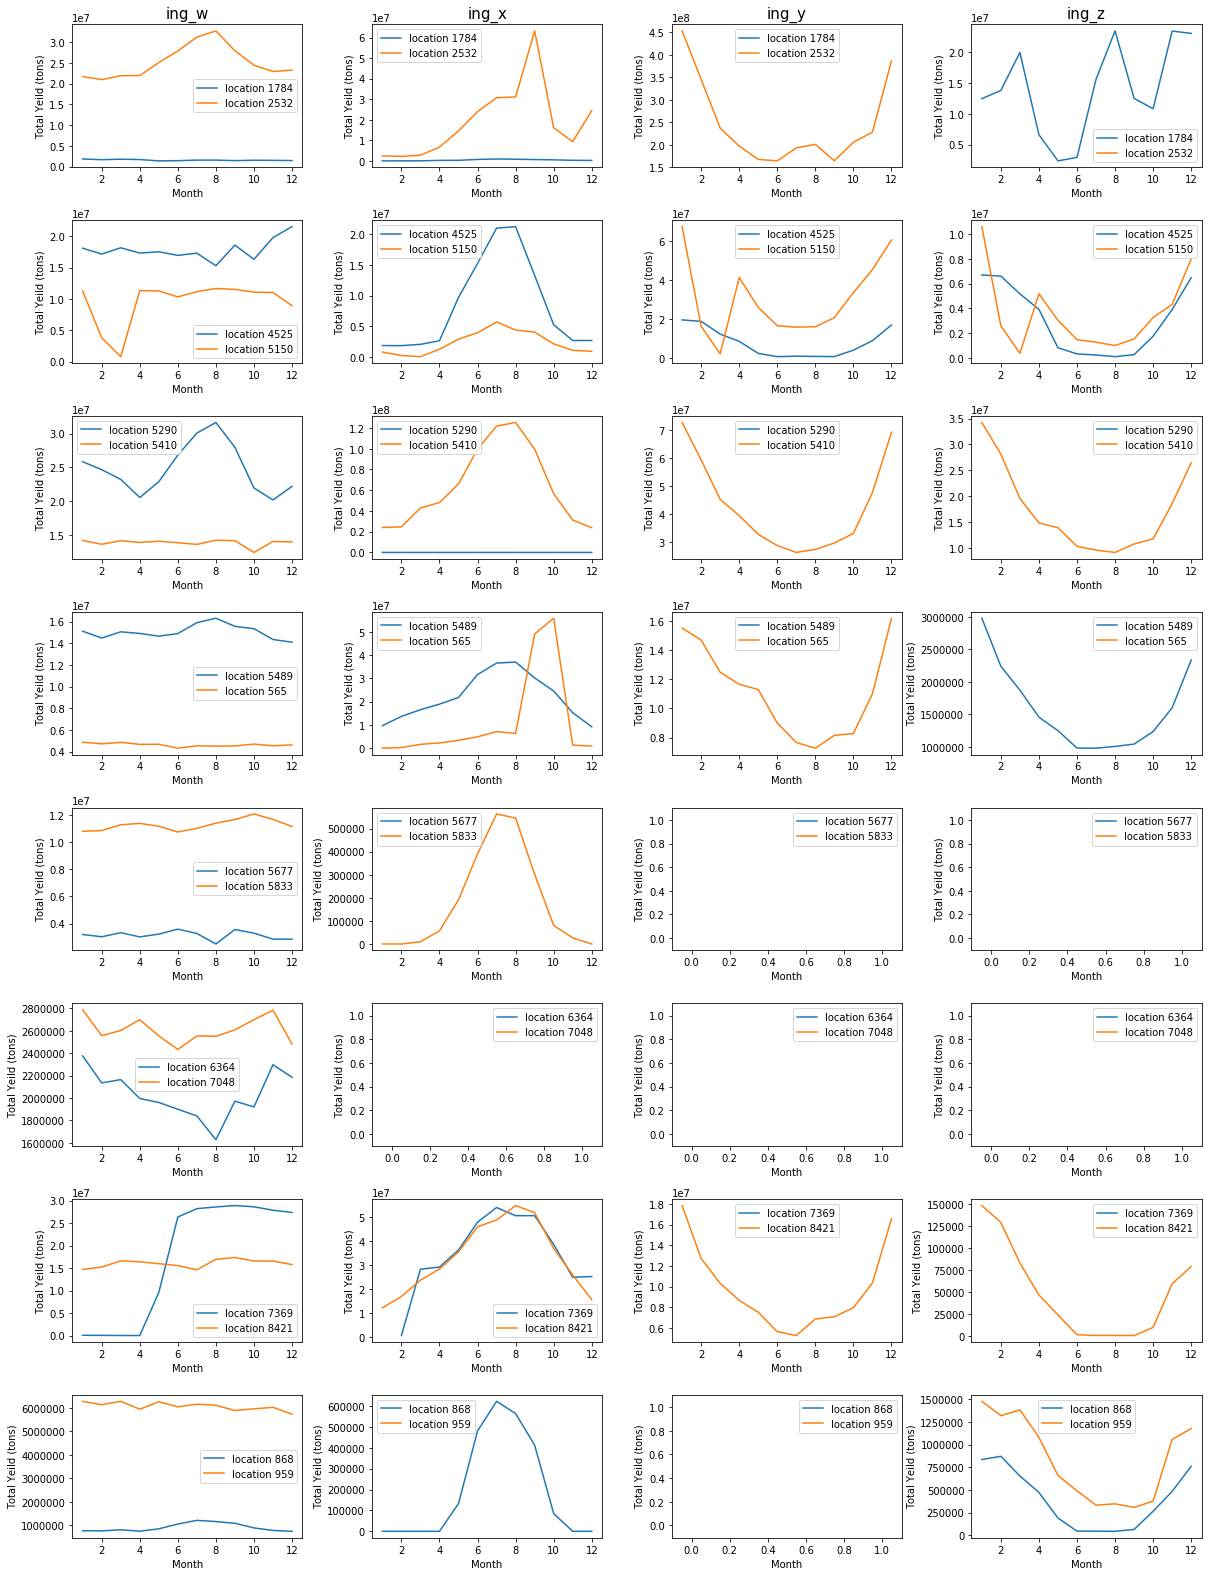

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(17,22))
for ing_idx,ing in enumerate(['ing_w','ing_x','ing_y','ing_z']):
    temp_dff=pd.DataFrame(final_merged_df[final_merged_df['ingredient_type']==ing]).\
            groupby(['deidentified_location','month'])['yield'].sum().unstack().T
    temp_dff.columns=[str(x) for x in list(temp_dff.columns)]
    temp_dff=my_reset_index(temp_dff)

    fig.tight_layout()
    count=0
    axes[count][ing_idx].set_title(ing,fontsize=15)
    for idx,col in enumerate(temp_dff.columns[1:]):
        
        axes[count][ing_idx].plot('month',col,data=temp_dff)
    
        show='n'
        if (idx+1)%2==0:
            
            axes[count][ing_idx].legend()
            show='y'
            axes[count][ing_idx].set_xlabel('Month')
            axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
        
            count+=1
    if show=='n':
        
        axes[count][ing_idx].legend()
        axes[count][ing_idx].set_xlabel('Month')
        axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
    


###Viewing the MONTH wise total trend of the yield in all the 16 farming companies for each particular ingredient 

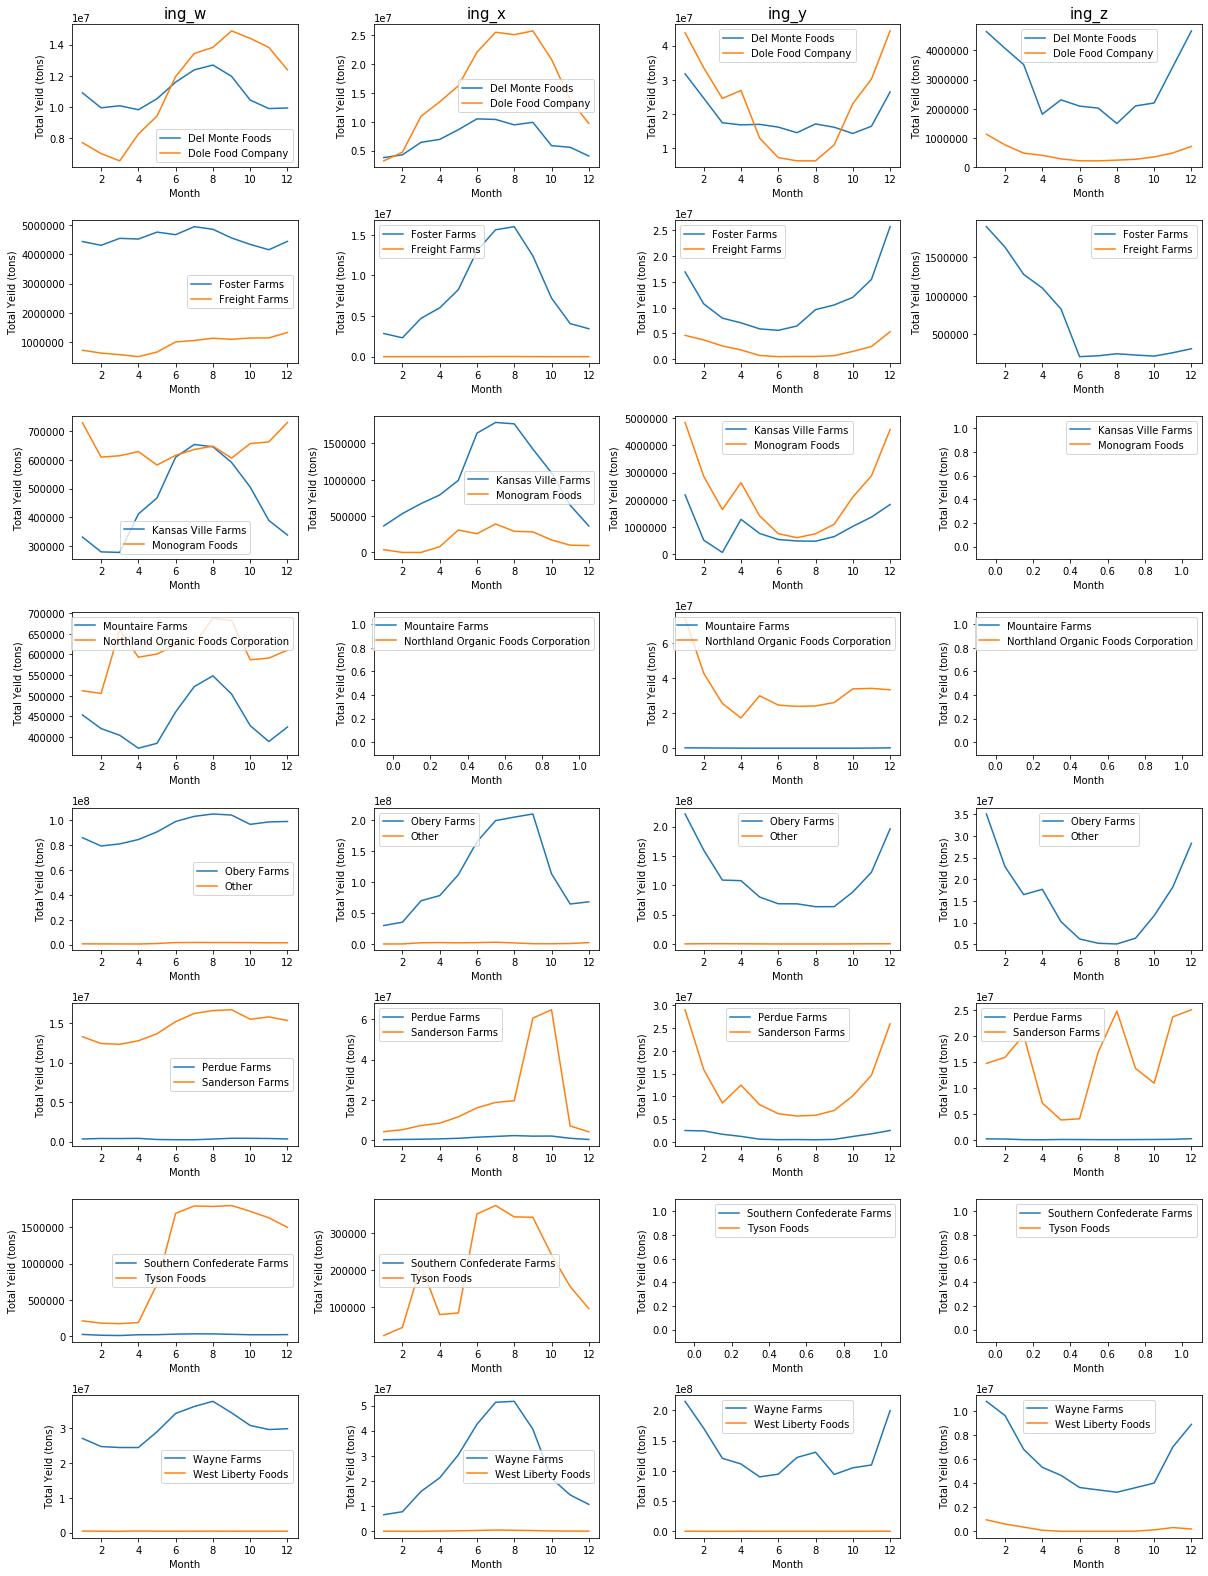

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(17,22))
for ing_idx,ing in enumerate(['ing_w','ing_x','ing_y','ing_z']):
    temp_dff=pd.DataFrame(final_merged_df[final_merged_df['ingredient_type']==ing]).\
            groupby(['farming_company','month'])['yield'].sum().unstack().T
    temp_dff.columns=[str(x) for x in list(temp_dff.columns)]
    temp_dff=my_reset_index(temp_dff)

    fig.tight_layout()
    count=0
    axes[count][ing_idx].set_title(ing,fontsize=15)
    for idx,col in enumerate(temp_dff.columns[1:]):
        
        axes[count][ing_idx].plot('month',col,data=temp_dff)
    
        show='n'
        if (idx+1)%2==0:

            axes[count][ing_idx].legend()
            show='y'
            axes[count][ing_idx].set_xlabel('Month')
            axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
        
            count+=1
    if show=='n':
        axes[count][ing_idx].legend()
        axes[count][ing_idx].set_xlabel('Month')
        axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
    


In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company',
       'deidentified_location', 'farm_area', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'day', 'month', 'hour'],
      dtype='object')

In [0]:
deidentified_locations=np.unique(final_merged_df['deidentified_location'])

###Viewing the yield of "ing_w" in all 16 deidentified locations along with the other climatic parameters, to see the impact of the climatic conditions on the yield in a single plot

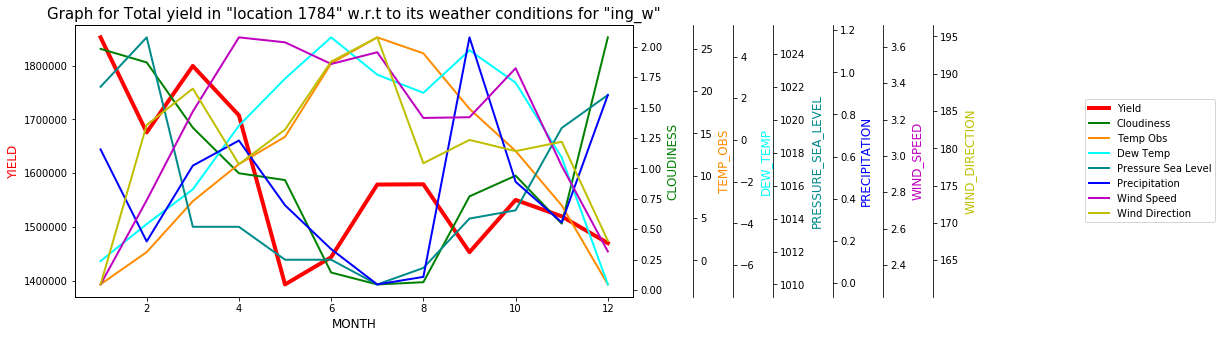

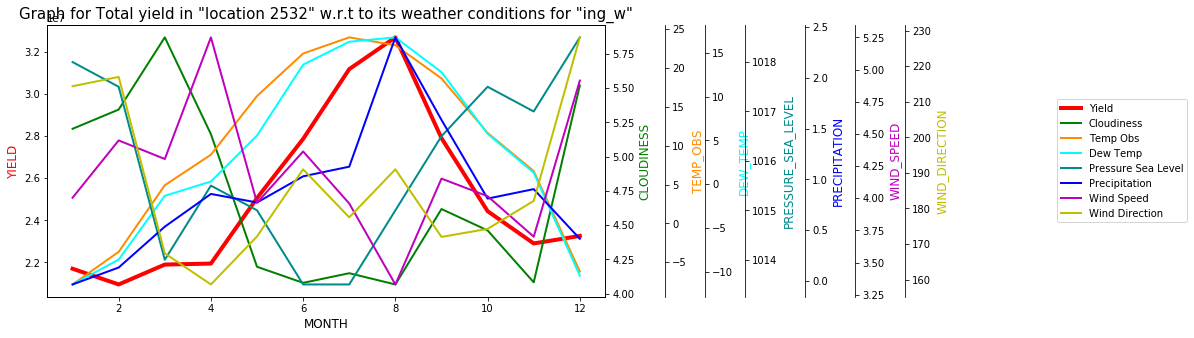

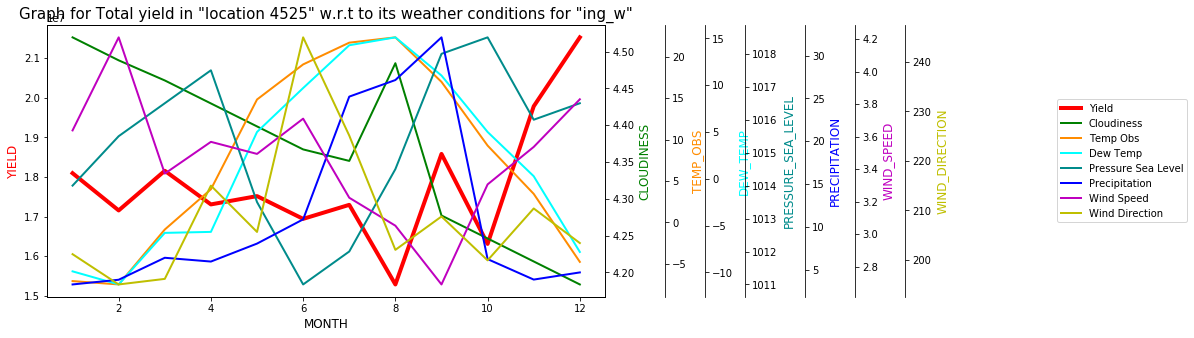

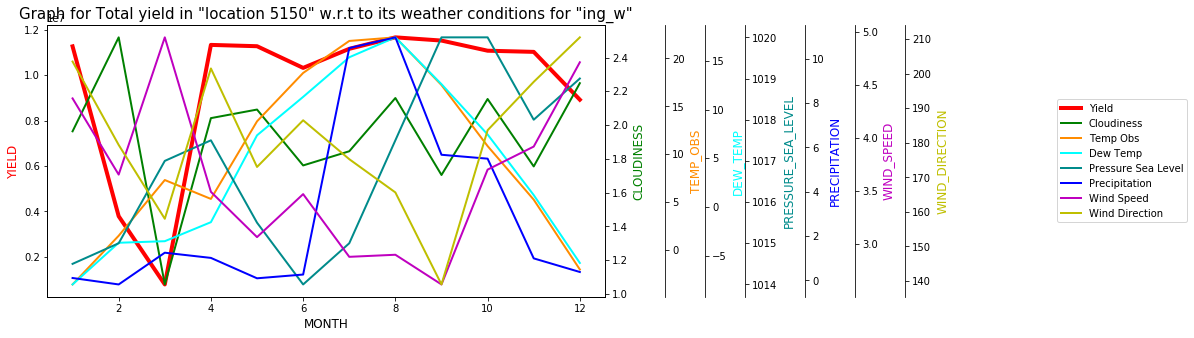

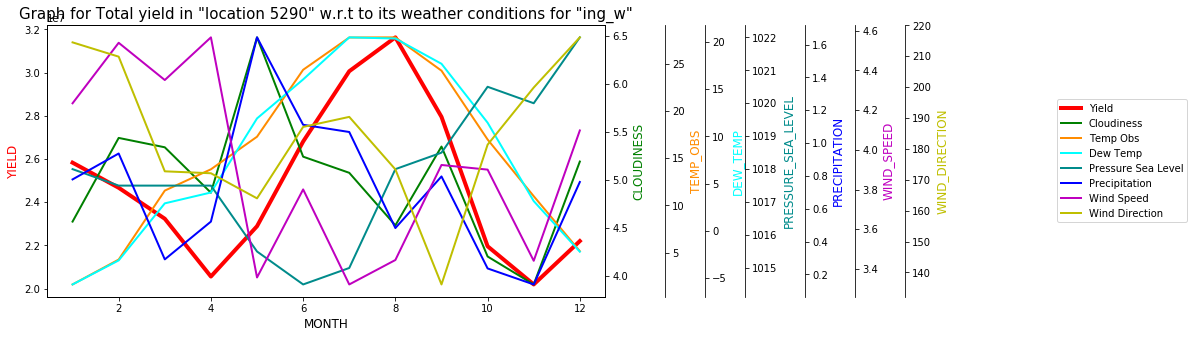

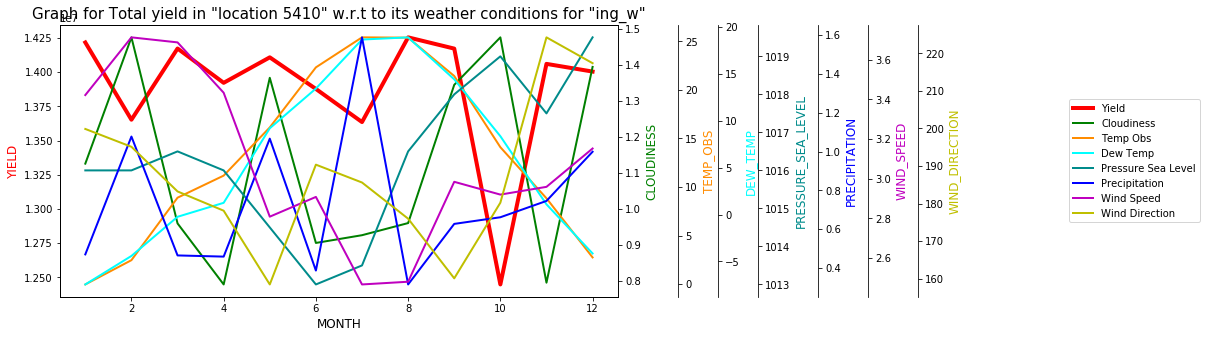

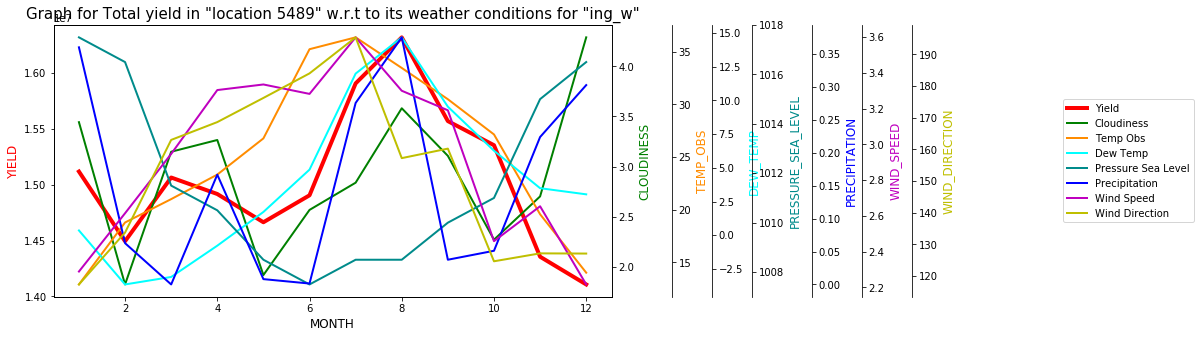

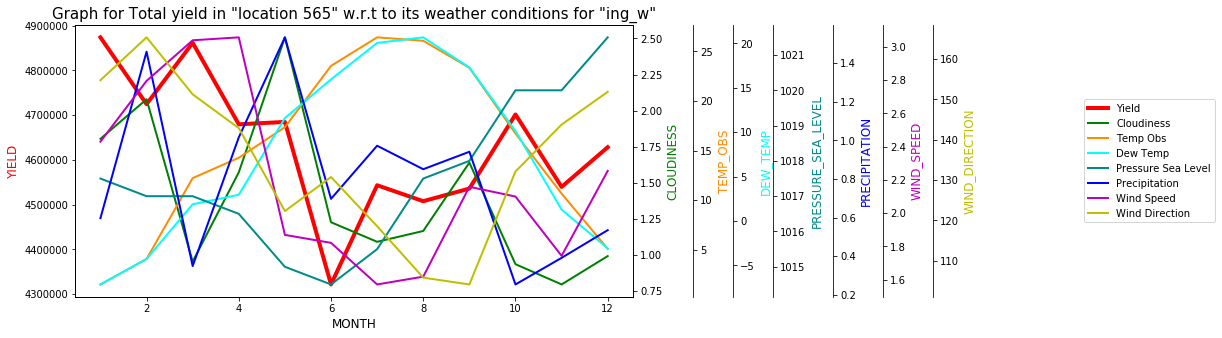

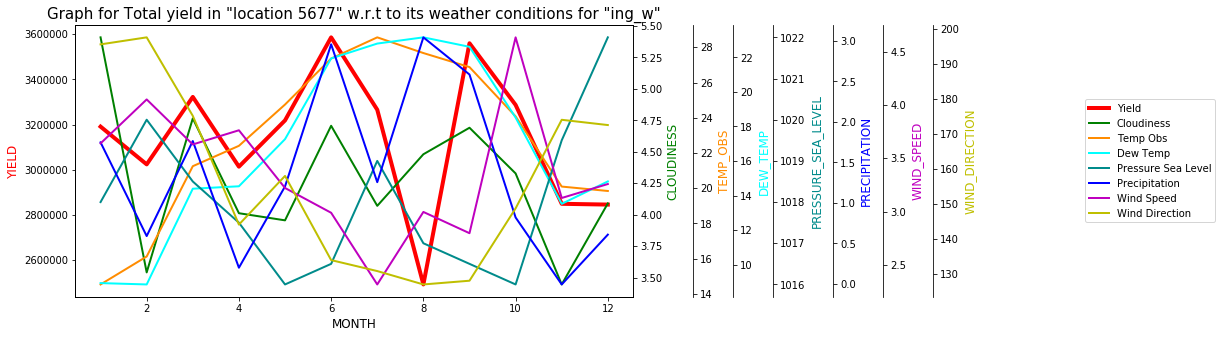

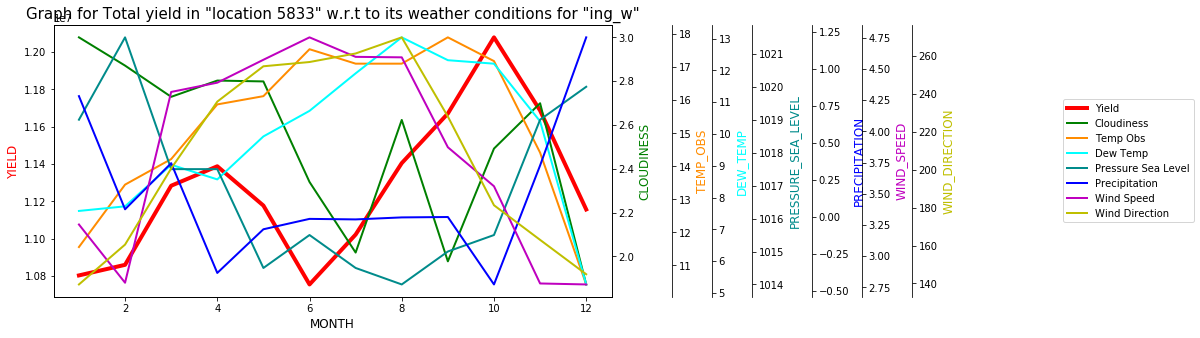

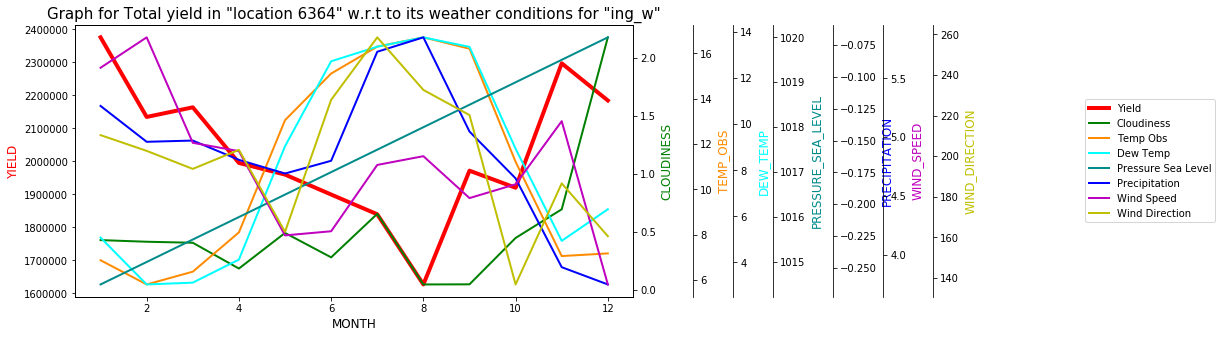

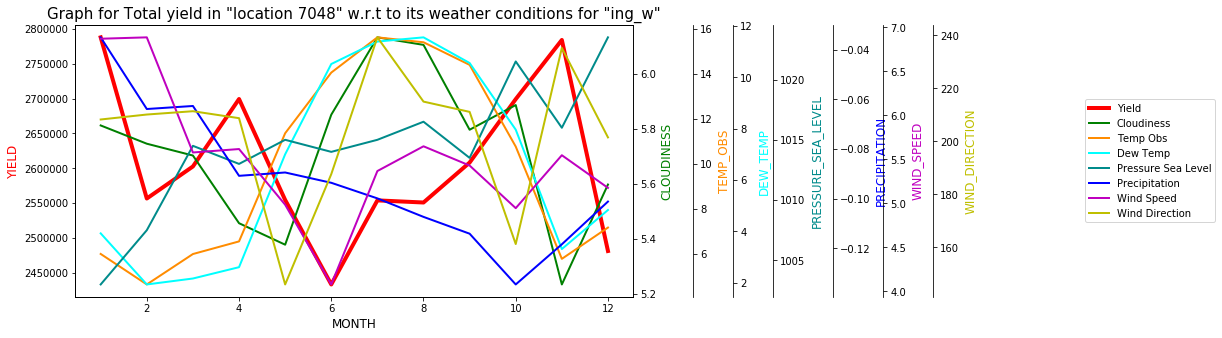

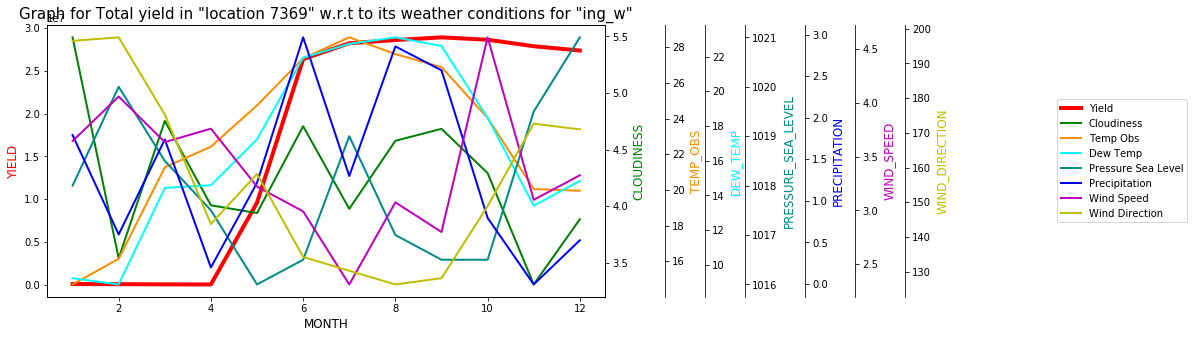

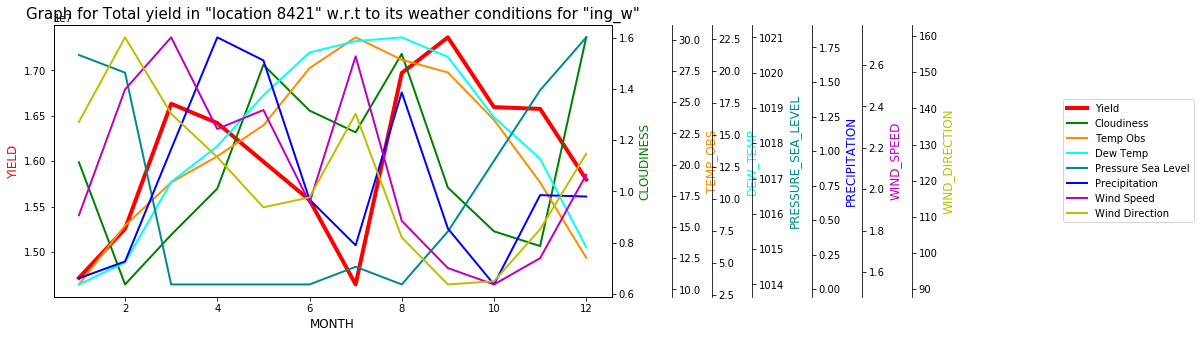

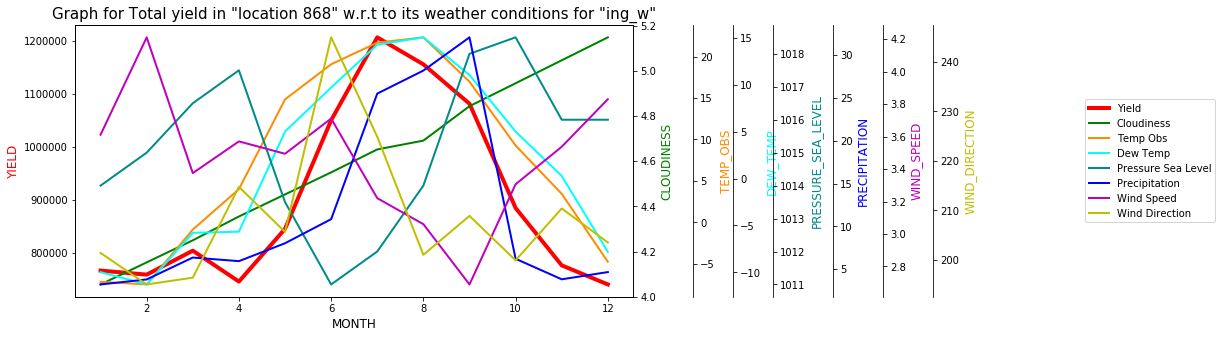

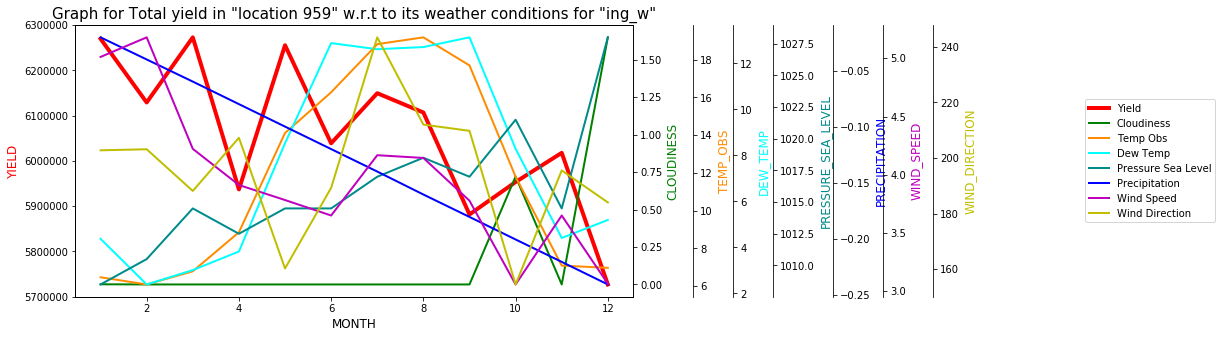

In [0]:
import matplotlib.pyplot as plt 

for loc in deidentified_locations:

  fig = plt.figure(figsize=(10,5))
  host = fig.add_subplot(111)

  par1 = host.twinx()
  par2 = host.twinx()
  par3 = host.twinx()
  par4 = host.twinx()
  par5 = host.twinx()
  par6 = host.twinx()
  par7 = host.twinx()

  host.set_xlabel(str.upper("MONTH"),fontsize=12)
  host.set_ylabel(str.upper("Yield"),fontsize=12)
  par1.set_ylabel(str.upper("cloudiness"),fontsize=12)
  par2.set_ylabel(str.upper("temp_obs"),fontsize=12)
  par3.set_ylabel(str.upper("dew_temp"),fontsize=12)
  par4.set_ylabel(str.upper("pressure_sea_level"),fontsize=12)
  par5.set_ylabel(str.upper("precipitation"),fontsize=12)
  par6.set_ylabel(str.upper("wind_speed"),fontsize=12)
  par7.set_ylabel(str.upper("wind_direction"),fontsize=12)

  months=np.unique(final_merged_df['month'])
  yield1=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['yield'].sum())
  cloudiness=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['cloudiness'].mean())

  tempobs=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['temp_obs'].mean())
  dew_temp=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['dew_temp'].mean())

  pressure_sea_level=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['pressure_sea_level'].mean())
  precipitation=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['precipitation'].mean())

  wind_speed=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['wind_speed'].mean())
  wind_direction=pd.DataFrame(final_merged_df[(final_merged_df['deidentified_location']==loc)&(final_merged_df['ingredient_type']=='ing_w')].\
                     groupby(['month'])['wind_direction'].mean())


  p1, = host.plot(months,yield1,color='r',label="Yield",linewidth=4)
  p2, = par1.plot(months,cloudiness,color='g',label="Cloudiness",linewidth=2)
  p3, = par2.plot(months,tempobs,color='darkorange',label="Temp Obs",linewidth=2)
  p4, = par3.plot(months,dew_temp,color='cyan',label="Dew Temp",linewidth=2)
  p5, = par4.plot(months,pressure_sea_level,color='darkcyan',label="Pressure Sea Level",linewidth=2)
  p6, = par5.plot(months,precipitation,color='b',label="Precipitation",linewidth=2)
  p7, = par6.plot(months,wind_speed,color='m',label="Wind Speed",linewidth=2)
  p8, = par7.plot(months,wind_direction,color='y',label="Wind Direction",linewidth=2)

  lns = [p1, p2, p3, p4, p5, p6, p7, p8]
  host.legend(handles=lns, loc='center left',bbox_to_anchor=(1.8, 0.5))

  par2.spines['right'].set_position(('outward', 60))  
  par3.spines['right'].set_position(('outward', 100)) 
  par4.spines['right'].set_position(('outward', 140)) 
  par5.spines['right'].set_position(('outward', 200)) 
  par6.spines['right'].set_position(('outward', 250)) 
  par7.spines['right'].set_position(('outward', 300)) 


  host.yaxis.label.set_color(p1.get_color())
  par1.yaxis.label.set_color(p2.get_color())
  par2.yaxis.label.set_color(p3.get_color())
  par3.yaxis.label.set_color(p4.get_color())
  par4.yaxis.label.set_color(p5.get_color())
  par5.yaxis.label.set_color(p6.get_color())
  par6.yaxis.label.set_color(p7.get_color())  
  par7.yaxis.label.set_color(p8.get_color())

  plt.title('Graph for Total yield in "'+loc+'" w.r.t to its weather conditions for "ing_w"',fontsize=15)
  plt.show()
  #break

In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company',
       'deidentified_location', 'farm_area', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'day', 'month', 'hour'],
      dtype='object')

In [0]:
train_weather3.columns

Index(['timestamp', 'deidentified_location', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

###Distribution of the total yield for a particular deidentified location

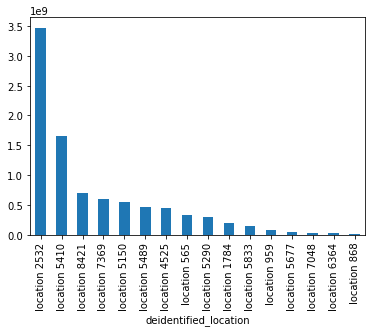

In [0]:
df=final_merged_df.groupby(['deidentified_location'])['yield'].sum().sort_values(ascending=False)
df.plot.bar()

###Ordinal encoding the deidentified location. Lower the yield in the above distribution, lower is the value assigned to its location, higher is the yield in the above distribution, higher is the value assigned to its location. Values assigned from 1 to 16, lower to higher

In [0]:
deid_list_oe=final_merged_df.groupby(['deidentified_location'])['yield'].sum().sort_values().index
deid_list_oe_dict = { deid_list_oe[i] : i+1 for i in range(0, len(deid_list_oe) ) }

In [0]:
print(deid_list_oe_dict)

{'location 868': 1, 'location 6364': 2, 'location 7048': 3, 'location 5677': 4, 'location 959': 5, 'location 5833': 6, 'location 1784': 7, 'location 5290': 8, 'location 565': 9, 'location 4525': 10, 'location 5489': 11, 'location 5150': 12, 'location 7369': 13, 'location 8421': 14, 'location 5410': 15, 'location 2532': 16}


###Distribution of the total yield for a particular farming company

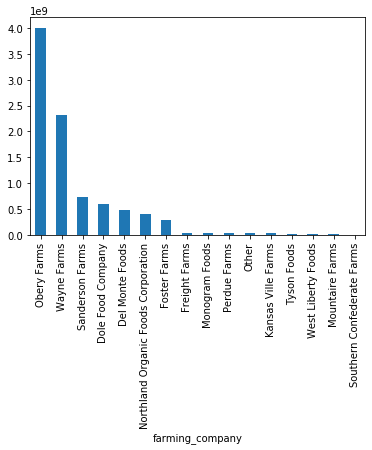

In [0]:
df=final_merged_df.groupby(['farming_company'])['yield'].sum().sort_values(ascending=False)
df.plot.bar()

###Ordinal encoding the farming company. Lower the yield in the above distribution, lower is the value assigned to its farming company, higher is the yield in the above distribution, higher is the value assigned to its farming company. Values assigned from 1 to 16, lower to higher

In [0]:
fc_list_oe=final_merged_df.groupby(['farming_company'])['yield'].sum().sort_values().index
fc_list_oe_dict = { fc_list_oe[i] : i+1 for i in range(0, len(fc_list_oe) ) }

In [0]:
print(fc_list_oe_dict)

{'Southern Confederate Farms': 1, 'Mountaire Farms': 2, 'West Liberty Foods': 3, 'Tyson Foods': 4, 'Kansas Ville Farms': 5, 'Other': 6, 'Perdue Farms': 7, 'Monogram Foods': 8, 'Freight Farms': 9, 'Foster Farms': 10, 'Northland Organic Foods Corporation': 11, 'Del Monte Foods': 12, 'Dole Food Company': 13, 'Sanderson Farms': 14, 'Wayne Farms': 15, 'Obery Farms': 16}


In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company',
       'deidentified_location', 'farm_area', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'day', 'month', 'hour'],
      dtype='object')

###Ordinal encoding the farm ids. Lower the yield , lower is the value assigned to its farm id, higher is the yield , higher is the value assigned to its farm id. Values assigned from 1 to 1434, lower to higher

In [0]:
fid_list_oe=final_merged_df.groupby(['farm_id'])['yield'].sum().sort_values().index

In [0]:
fid_list_oe_dict = { fid_list_oe[i] : i+1 for i in range(0, len(fid_list_oe) ) }


In [0]:
len(fid_list_oe_dict.keys())

1434

In [0]:
final_merged_df_cols=list(final_merged_df.columns)

###Ordinal Encoding farming company

In [0]:
mappings=[{'col':'farming_company','mapping':fc_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

###Ordinal Encoding deidentified location

In [0]:
mappings=[{'col':'deidentified_location','mapping':deid_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

###Ordinal Encoding farm ids

In [0]:
mappings=[{'col':'farm_id','mapping':fid_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

In [0]:
final_merged_df.shape

(20216100, 17)

In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'yield', 'farming_company',
       'deidentified_location', 'farm_area', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed', 'day', 'month', 'hour'],
      dtype='object')

In [0]:
final_merged_df.head(3)

date  farm_id ingredient_type      yield  farming_company  \
0 2016-01-01 00:00:00      469           ing_w  37.040001               12   
1 2016-01-01 01:00:00      469           ing_w  37.119999               12   
2 2016-01-01 02:00:00      469           ing_w  37.779999               12   

   deidentified_location    farm_area   temp_obs  cloudiness  wind_direction  \
0                      8  2043.865967  10.000000         8.0           350.0   
1                      8  2043.865967   9.398438         8.0           350.0   
2                      8  2043.865967   8.898438         8.0            10.0   

   dew_temp  pressure_sea_level  precipitation  wind_speed  day  month  hour  
0  2.199219              1021.0            0.0    4.101562    1      1     0  
1  2.800781              1021.5            0.0    6.199219    1      1     1  
2  2.199219              1021.5            0.0    4.601562    1      1     2

###Dummifying the ingredient_type column

In [0]:
final_merged_df=pd.get_dummies(final_merged_df,drop_first=True,columns=['ingredient_type'])

In [0]:
final_merged_df.shape

(20216100, 19)

In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'yield', 'farming_company', 'deidentified_location',
       'farm_area', 'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

###Droping the date column, we already had created month,day and hour columns from this column

In [0]:
final_merged_df.drop(['date'],axis=1,inplace=True)

In [0]:
final_merged_df.head(2)

farm_id      yield  farming_company  deidentified_location    farm_area  \
0      469  37.040001               12                      8  2043.865967   
1      469  37.119999               12                      8  2043.865967   

    temp_obs  cloudiness  wind_direction  dew_temp  pressure_sea_level  \
0  10.000000         8.0           350.0  2.199219              1021.0   
1   9.398438         8.0           350.0  2.800781              1021.5   

   precipitation  wind_speed  day  month  hour  ingredient_type_ing_x  \
0            0.0    4.101562    1      1     0                      0   
1            0.0    6.199219    1      1     1                      0   

   ingredient_type_ing_y  ingredient_type_ing_z  
0                      0                      0  
1                      0                      0

###Shape of the final_merged dataset

In [0]:
final_merged_df.shape

(20216100, 18)

In [0]:
final_merged_df.columns

Index(['farm_id', 'yield', 'farming_company', 'deidentified_location',
       'farm_area', 'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

In [0]:
final_merged_df_train=final_merged_df.copy()

In [0]:
del [final_merged_df2,final_merged_df_sc]

###Creating the train-validation datasets

In [0]:
y_train_full = final_merged_df['yield']
X_train_full = final_merged_df.copy().drop("yield",axis=1)

X_train,X_val,y_train,y_val=train_test_split(X_train_full,y_train_full,test_size=.09,random_state=123)

In [0]:
del [X_train_full,y_train_full]

In [0]:
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(18396651, 17) (1819449, 17) (18396651,) (1819449,)


###RMSE scores with Decision Tree Algorithm

In [0]:

lm = DecisionTreeRegressor(min_samples_split=25, max_features='auto')
lm.fit(X_train,y_train)
y_train_pred_lm_be = lm.predict(X_train)
y_val_pred_lm_be = lm.predict(X_val)
print("=================================================================================")
print("Train RMSE of Decision Tree:",np.sqrt(mean_squared_error(y_train, y_train_pred_lm_be)))
print("Validation RMSE of Decision Tree :",np.sqrt(mean_squared_error(y_val, y_val_pred_lm_be)))


Train RMSE of Decision Tree: 1057.091912123424
Validation RMSE of Decision Tree : 1386.480570488742


###Learning Curves

([2591233.9388914322,
  1941628.346277541,
  1395640.8791117172,
  1449395.523489785,
  1312452.9726910628,
  1112634.713920533,
  1111013.6935037274,
  1123810.4349892626,
  1140006.1481635626,
  1117442.2762876635],
 [4603681.006428718,
  3134972.859836375,
  3085319.7942634053,
  2515921.809488197,
  2200495.289949053,
  2095833.3657728534,
  2382003.213190325,
  1940478.6373826272,
  1906810.880835332,
  1922399.0713028386])

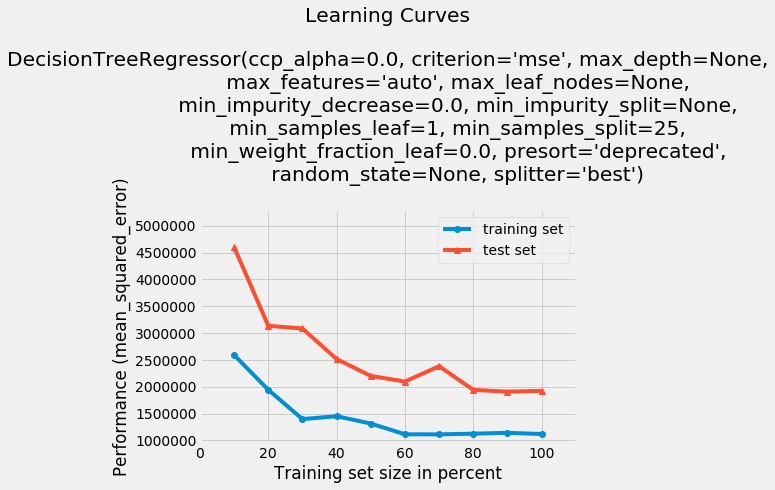

In [0]:
plot_learning_curves(X_train, y_train, X_val, y_val, lm, scoring='mean_squared_error')

In [0]:
del [farm3_weather3_df,farm_comp,farm_data3,farm_data33,farm_data333]

In [0]:
del [train_data3,train_data33]

###Reading the Test datasets

In [0]:
farm_data=pd.read_csv('/content/drive/My Drive/farm_data.csv')
test_weather=pd.read_csv('/content/drive/My Drive/test_weather.csv')
test_data=pd.read_csv('/content/drive/My Drive/test_data.csv')

###Performing all the operations performed on train dataset
1. Type casting to lower data types for memory management
2. Finding the duplciate records in test dataset when farm_id,date and ingredient type are grouped
3. Mapping the test dataset duplicate records and non-duplicate records with the corresponding the deidentified location and farming company information from farm dataset
4. Merging farm dataset and test weather dataset on deidentified location
5. Finally merging test dataset and farm-test_weather dataset
6. Creating the new columns created as part of feature engineering for train dataset
7. Dummifying and Ordinal encoding the farm_id, deidentified lcoation and farming company using the same encodings used for train dataset


In [0]:
test_data3=test_data.copy()

test_data3.date =  pd.to_datetime(test_data3.date, infer_datetime_format=True)
test_data3.farm_id=test_data3.farm_id.astype('category')
test_data3.ingredient_type=test_data3.ingredient_type.astype('category')

In [0]:
test_weather3=test_weather.copy()

test_weather3.timestamp =  pd.to_datetime(test_weather3.timestamp, infer_datetime_format=True)
test_weather3.deidentified_location = test_weather3.deidentified_location.astype('category')

In [0]:
farm_data3=farm_data.copy()

farm_data3.deidentified_location = farm_data3.deidentified_location.astype('category')
farm_data3.farm_id = farm_data3.farm_id.astype('category')
farm_data3.farming_company = farm_data3.farming_company.astype('category')

In [0]:
test_weather3['temp_obs']=test_weather3['temp_obs'].astype(np.float16)
test_weather3['cloudiness']=test_weather3['cloudiness'].astype(np.float16)
test_weather3['wind_direction']=test_weather3['wind_direction'].astype(np.float16)
test_weather3['dew_temp']=test_weather3['dew_temp'].astype(np.float16)
test_weather3['pressure_sea_level']=test_weather3['pressure_sea_level'].astype(np.float16)
test_weather3['precipitation']=test_weather3['precipitation'].astype(np.float16)
test_weather3['wind_speed']=test_weather3['wind_speed'].astype(np.float16)

In [0]:
farm_data3['operations_commencing_year']=farm_data3['operations_commencing_year'].astype(np.float16)
farm_data3['num_processing_plants']=farm_data3['num_processing_plants'].astype(np.float16)
farm_data3['farm_area']=farm_data3['farm_area'].astype(np.float32)

In [0]:
dup_fids=list(farm_data3[farm_data3['farm_id'].duplicated()]['farm_id'])

In [0]:
test_data3_grouped=test_data3.groupby(['farm_id','date','ingredient_type'])['id'].size().unstack()

In [0]:
test_data3_grouped2=test_data3_grouped[(test_data3_grouped['ing_w']>1)|(test_data3_grouped['ing_x']>1)|(test_data3_grouped['ing_y']>1)|\
                   (test_data3_grouped['ing_z']>1)]
test_data3_grouped2.columns=[str(x) for x in list(test_data3_grouped2.columns)]
test_data3_grouped2=my_reset_index(test_data3_grouped2)
test_data3_grouped2.head()  

farm_id                date  ing_w  ing_x  ing_y  ing_z
0  fid_122174 2017-01-01 00:00:00    2.0    1.0    1.0    NaN
1  fid_122174 2017-01-01 01:00:00    2.0    1.0    1.0    NaN
2  fid_122174 2017-01-01 02:00:00    2.0    1.0    1.0    NaN
3  fid_122174 2017-01-01 03:00:00    2.0    1.0    1.0    NaN
4  fid_122174 2017-01-01 04:00:00    2.0    1.0    1.0    NaN

In [0]:
mul_rec_fids=list(np.unique(test_data3_grouped2['farm_id']))

In [0]:
#### Separated the duplicated farm id records
test_data3_dups=test_data3[test_data3['farm_id'].isin(mul_rec_fids)]

In [0]:
test_data3_dups=test_data3_dups.sort_values(['farm_id','date','ingredient_type','id'])

In [0]:
test3_dups_farm3_dups_df=test_data3_dups.merge(farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id'),left_on='farm_id',right_on='farm_id')

In [0]:

#We want to view the crops that are present in a paricular farm and where the farm is located
dup_farm_loc_list=list(test3_dups_farm3_dups_df.groupby(['farm_id','deidentified_location','farming_company','ingredient_type'])['ingredient_type'].size().index)
    
res = get_dict_list(dup_farm_loc_list,4)
res2={}
res3={}

for key,values in res.items():
    res2[key]=get_dict_list(values,3)

print('---------------------------------------------------------------------------------------------') 
for k,v in res2.items():
    print(k)
    for k2,v2 in v.items():
        l=[]
        for ing in v2:
            l+=list(ing)
        l1=np.unique(l[0::2])
        l2=np.unique(l[1::2])
        #print(k,)
        print('    ',l2,'--->',k2,'--->',l1)
    print('---------------------------------------------------------------------------------------------')


---------------------------------------------------------------------------------------------
fid_122174
     ['ing_w' 'ing_x' 'ing_y'] ---> location 2532 ---> ['Dole Food Company' 'Wayne Farms']
---------------------------------------------------------------------------------------------
fid_18990
     ['ing_w'] ---> location 5290 ---> ['Obery Farms']
     ['ing_w'] ---> location 5833 ---> ['Obery Farms']
---------------------------------------------------------------------------------------------
fid_26064
     ['ing_w' 'ing_x' 'ing_y'] ---> location 2532 ---> ['Obery Farms']
     ['ing_w' 'ing_x' 'ing_y'] ---> location 5290 ---> ['Del Monte Foods']
---------------------------------------------------------------------------------------------
fid_29387
     ['ing_w'] ---> location 5833 ---> ['Obery Farms']
     ['ing_w'] ---> location 7048 ---> ['Wayne Farms']
---------------------------------------------------------------------------------------------
fid_40459
     ['ing_w'] ---> lo

In [0]:
farm_data33=farm_data3[farm_data3['farm_id'].isin(dup_fids)].sort_values('farm_id')

In [0]:
farm_data33['ings']=['ing_w ing_x','dups_ing_w ing_y','dups_ing_w','ing_w','dups_ing_w ing_y ing_x','ing_w','dups_ing_w','ing_w',\
'dups_ing_w','ing_w','ing_w ing_x','dups_ing_w','ing_w','dups_ing_w','ing_w','dups_ing_w','ing_w ing_x ing_y',\
'dups_ing_w dups_ing_x ing_z','ing_w ing_x ing_z','dups_ing_w','dups_ing_w','ing_w','dups_ing_w','ing_w',\
'ing_w ing_x ing_z','dups_ing_w','dups_ing_w','ing_w','ing_w ing_x','dups_ing_w']

In [0]:
farm_data333=farm_data33.sort_values(['farm_id','ings'],ascending=False)


In [0]:

indexes2={}
for fid in mul_rec_fids:
    # taking row indexes of farms data from test dataset, all indexes excluding the duplicate record indexes
    indexes2['nondup-'+fid]=list(test_data3_dups[(test_data3_dups['farm_id']==fid)&~(test_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].index)
    
    # taking row indexes of farms data from test dataset, only the duplicate record indexes
    indexes2['dup-'+fid]=list(test_data3_dups[(test_data3_dups['farm_id']==fid)&(test_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())].index)
    
    # from the above farm_data333 dataframe taking the non-dups_ings information for a particular farm id that are along with the dups_ings
    # If there are no non-dups_ings for a farm id, we get empty list. Example: for fid_97094 we get empty, for fid_26064 we get
    # ['ing_y', 'ing_x'] as we have dups_ings i.e dups_ing_w along with them
    dups_loc_non_dups=[i for i in list(farm_data333[farm_data333['farm_id']==fid].tail(1)['ings'].values)[0].split() if 'dups_' not in i]
    
    # taking row indexes of farms data from test dataset, all indexes of the non-dups_ings extracted above specific to 
    # a particular farm 
    if len(dups_loc_non_dups):
        indexes2['dupslocnondup-'+fid]=list(test_data3_dups[(test_data3_dups['farm_id']==fid)&~(test_data3_dups.loc[:,['farm_id','date','ingredient_type']].duplicated())&(test_data3_dups['ingredient_type'].isin(dups_loc_non_dups))].index)


In [0]:
test_data33=test_data3.copy()

In [0]:
#element is a variable to control the below flow of code
element=1

for key,idx_value in indexes2.items():
    
    fid=key.split('-')[1]
    
    if (key.split('-')[0]!='dupslocnondup')&(element==3):
        # if there are no dupslocnondup- for a file id making element = 1 to control the below execution flow
        element=1
        
    if(element==1):
        # this code is for nondup- indexes
        
       
        
        # Extracting farming_company and deidentified_location particular a farm_id
        farm_comp=farm_data333[farm_data333['farm_id']==fid].head(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].head(1)['deidentified_location'].values[0]
        
        
        test_data33.loc[(test_data33.index.isin(idx_value)),'farming_company']=farm_comp                      
        
                
        test_data33.loc[(test_data33.index.isin(idx_value)),'deidentified_location']=deid_loc
                            
        prev_idx_value=idx_value
        
        element=2
        
    elif element==2:
        # this code is for dup- indexes
        
        
        farm_comp=farm_data333[farm_data333['farm_id']==fid].tail(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].tail(1)['deidentified_location'].values[0]
        
        
        test_data33.loc[(test_data33.index.isin(idx_value)),'farming_company']=farm_comp
        
                 
        test_data33.loc[(test_data33.index.isin(idx_value)),'deidentified_location']=deid_loc

        element=3
    else:
        # this code is for dupslocnondup- indexes
        
       
        farm_comp=farm_data333[farm_data333['farm_id']==fid].tail(1)['farming_company'].values[0]
        deid_loc=farm_data333[farm_data333['farm_id']==fid].tail(1)['deidentified_location'].values[0]
        
        
        test_data33.loc[(test_data33.index.isin(idx_value)),'farming_company']=farm_comp
        
        
        test_data33.loc[(test_data33.index.isin(idx_value)),'deidentified_location']=deid_loc
        
        element=1
    


In [0]:
test_data33.farming_company=test_data33.farming_company.astype('category')
test_data33.deidentified_location=test_data33.deidentified_location.astype('category')

In [0]:
test_data33_nondups=test_data33[~(test_data33['farm_id'].isin(mul_rec_fids))]

In [0]:
test_data33_nondups_farm3_df=test_data33_nondups.merge(farm_data3,left_on=['farm_id'],right_on=['farm_id'])

In [0]:
test_data33_nondups_farm3_df=test_data33_nondups_farm3_df.loc[:,['date', 'farm_id', 'ingredient_type', 'id', 'farming_company_y',\
                                                                   'deidentified_location_y']]

In [0]:
test_data33_nondups_farm3_df.columns=['date', 'farm_id', 'ingredient_type', 'id', 'farming_company','deidentified_location']

In [0]:
test_data_final=pd.concat([test_data33_nondups_farm3_df,test_data33[test_data33['farm_id'].isin(mul_rec_fids)]],axis=0)

In [0]:
test_data_final=test_data_final.sort_values(['farm_id','date','ingredient_type','id'])

In [0]:
test_data_final.farming_company=test_data_final.farming_company.astype('category')
test_data_final.deidentified_location=test_data_final.deidentified_location.astype('category')

In [0]:
farm3_weather3_df=farm_data3.merge(test_weather3,left_on=['deidentified_location'],right_on=['deidentified_location'])

In [0]:
final_merged_df=test_data_final.merge(farm3_weather3_df,how='left',left_on=['farm_id','date','farming_company','deidentified_location'],\
                                      right_on=['farm_id','timestamp','farming_company','deidentified_location'])

In [0]:
final_merged_df['wind_speed']=final_merged_df['wind_speed'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['wind_direction']=final_merged_df['wind_direction'].interpolate(method ='linear', limit_direction ='forward')

In [0]:
final_merged_df['temp_obs']=final_merged_df['temp_obs'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['pressure_sea_level']=final_merged_df['pressure_sea_level'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['precipitation']=final_merged_df['precipitation'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['farm_area']=final_merged_df['farm_area'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['dew_temp']=final_merged_df['dew_temp'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['cloudiness']=final_merged_df['cloudiness'].interpolate(method ='linear', limit_direction ='forward')
final_merged_df['precipitation']=final_merged_df['precipitation'].interpolate(method ='linear', limit_direction ='backward')


In [0]:
final_merged_df.drop(['num_processing_plants'],axis=1,inplace=True)
final_merged_df.drop(['operations_commencing_year'],axis=1,inplace=True)
final_merged_df.drop(['timestamp'],axis=1,inplace=True)


In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'ingredient_type', 'id', 'farming_company',
       'deidentified_location', 'farm_area', 'temp_obs', 'cloudiness',
       'wind_direction', 'dew_temp', 'pressure_sea_level', 'precipitation',
       'wind_speed'],
      dtype='object')

In [0]:
final_merged_df['day']=pd.DatetimeIndex(final_merged_df['date']).day
final_merged_df['day']=final_merged_df['day'].astype(np.uint8)
final_merged_df['month']=pd.DatetimeIndex(final_merged_df['date']).month
final_merged_df['month']=final_merged_df['month'].astype(np.uint8)
final_merged_df['hour']=final_merged_df['date'].dt.hour
final_merged_df['hour']=final_merged_df['hour'].astype(np.uint8)

In [0]:
final_merged_df_viz=final_merged_df.copy()

In [0]:
final_merged_df.shape

(20848800, 17)

In [0]:
final_merged_df_cols=list(final_merged_df.columns)

In [0]:
mappings=[{'col':'farming_company','mapping':fc_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

In [0]:
mappings=[{'col':'deidentified_location','mapping':deid_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

In [0]:
mappings=[{'col':'farm_id','mapping':fid_list_oe_dict}
          ]

oe=OrdinalEncoder(mapping=mappings)

final_merged_df=oe.fit_transform(final_merged_df)
final_merged_df=pd.DataFrame(final_merged_df,columns=final_merged_df_cols)

In [0]:
final_merged_df.shape

(20848800, 17)

In [0]:
final_merged_df=pd.get_dummies(final_merged_df,drop_first=True,columns=['ingredient_type'])

In [0]:
final_merged_df.shape

(20848800, 19)

In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'id', 'farming_company', 'deidentified_location',
       'farm_area', 'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

In [0]:
final_merged_df.head(2)

date  farm_id       id  farming_company  \
0 2017-01-01 00:00:00      469  8412446               12   
1 2017-01-01 01:00:00      469  8412720               12   

   deidentified_location    farm_area  temp_obs  cloudiness  wind_direction  \
0                      8  2043.865967  8.898438         8.0           190.0   
1                      8  2043.865967  8.296875         8.0           210.0   

   dew_temp  pressure_sea_level  precipitation  wind_speed  day  month  hour  \
0 -5.601562              1015.5           -1.0    8.203125    1      1     0   
1 -4.398438              1015.0           -1.0    8.796875    1      1     1   

   ingredient_type_ing_x  ingredient_type_ing_y  ingredient_type_ing_z  
0                      0                      0                      0  
1                      0                      0                      0

In [0]:
del[ test_data33_nondups_farm3_df,test_data3_dups]

In [0]:
del[test3_dups_farm3_dups_df,test_data3_grouped,test_data3_grouped2]

In [0]:
del[farm_data,farm_data33,farm_data333]

In [0]:
final_merged_df.shape

(20848800, 19)

In [0]:
final_merged_df.columns

Index(['date', 'farm_id', 'id', 'farming_company', 'deidentified_location',
       'farm_area', 'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z'],
      dtype='object')

In [0]:
final_merged_df.head(2)

date  farm_id       id  farming_company  \
0 2017-01-01 00:00:00      469  8412446               12   
1 2017-01-01 01:00:00      469  8412720               12   

   deidentified_location    farm_area  temp_obs  cloudiness  wind_direction  \
0                      8  2043.865967  8.898438         8.0           190.0   
1                      8  2043.865967  8.296875         8.0           210.0   

   dew_temp  pressure_sea_level  precipitation  wind_speed  day  month  hour  \
0 -5.601562              1015.5           -1.0    8.203125    1      1     0   
1 -4.398438              1015.0           -1.0    8.796875    1      1     1   

   ingredient_type_ing_x  ingredient_type_ing_y  ingredient_type_ing_z  
0                      0                      0                      0  
1                      0                      0                      0

In [0]:
X_test=final_merged_df.copy()

In [0]:
X_test.drop(['date','id'],axis=1,inplace=True)

In [0]:
X_test.shape

(20848800, 17)

In [0]:
X_test.head(5)

farm_id  farming_company  deidentified_location    farm_area  temp_obs  \
0      469               12                      8  2043.865967  8.898438   
1      469               12                      8  2043.865967  8.296875   
2      469               12                      8  2043.865967  8.898438   
3      469               12                      8  2043.865967  8.296875   
4      469               12                      8  2043.865967  7.800781   

   cloudiness  wind_direction  dew_temp  pressure_sea_level  precipitation  \
0         8.0           190.0 -5.601562              1015.5           -1.0   
1         8.0           210.0 -4.398438              1015.0           -1.0   
2         8.0           210.0 -5.601562              1014.5           -1.0   
3         8.0           200.0 -5.000000              1014.5            0.0   
4         5.0           210.0 -5.000000              1015.0            0.0   

   wind_speed  day  month  hour  ingredient_type_ing_x  ingredient_type_ing_y  \
0    8.203125    1      1     0                      0                      0   
1    8.796875    1      1     1                      0                      0   
2    7.199219    1      1     2                      0                      0   
3    6.199219    1      1     3                      0                      0   
4    5.699219    1      1     4                      0                      0   

   ingredient_type_ing_z  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0

###Predicting the yield values for test dataset

In [0]:
y_test_pred=lm.predict(X_test)

###Min value predicted

In [0]:
np.min(y_test_pred)

0.0

###Max value predicted

In [0]:
np.max(y_test_pred)

439656.0

In [0]:
X_test['yield']=y_test_pred

In [0]:
X_test.columns

Index(['farm_id', 'farming_company', 'deidentified_location', 'farm_area',
       'temp_obs', 'cloudiness', 'wind_direction', 'dew_temp',
       'pressure_sea_level', 'precipitation', 'wind_speed', 'day', 'month',
       'hour', 'ingredient_type_ing_x', 'ingredient_type_ing_y',
       'ingredient_type_ing_z', 'yield'],
      dtype='object')

# Creating a strategy to source ‘ing_w’ ingredient type 
Below is the forecasted demand for the next year for ‘ing_w’, using the model you  built, create a sourcing strategy for ‘ing_w’ such that the following conditions hold:    
● You should source the ingredient at least a month before   
● The ingredient has a long shelf life, capable of being used for at least 8  months once stocked  


####Calculating the total yield for ing_w in 12th month in 2016. As this will be present as available supply for the start of the month demand of 1st month 2017, as the total yield produced in the 1st month can only be used in the subsequent months but not the 1st month, as the yield will be produced by end of month and the demand for a month is from the start of the month

In [0]:
supply_2016_december_ing_w=pd.DataFrame(final_merged_df_train[(final_merged_df_train['ingredient_type_ing_x']==0)\
                           &(final_merged_df_train['ingredient_type_ing_y']==0)\
                           &(final_merged_df_train['ingredient_type_ing_z']==0)\
                           &(final_merged_df_train['month']==12)].\
                           groupby(['month'])['yield'].sum())

In [0]:
supply_2016_december_ing_w

yield
month           
12     174.73732

####Calculating the total yield predicted for "ing_w", month wise

In [0]:
supply_df=pd.DataFrame(X_test[(X_test['ingredient_type_ing_x']==0)&(X_test['ingredient_type_ing_y']==0)&(X_test['ingredient_type_ing_z']==0)].groupby(['month'])['yield'].sum())


####Creating a dataframe with the given demand information for "ing_w", month wise

In [0]:
month=list(range(1,13))
month
demand=[90430481,75344853,91917783,82591524,87419669,297500000,198900000,97367031,91049286,91755300,86533266,88514610]

In [0]:
demand_df=pd.DataFrame(month,columns=['month'])
demand_df['demand']=demand
demand_df.set_index(['month'],inplace=True)


In [0]:
supply_df['yield']=supply_df['yield'].astype(np.int64)

In [0]:
supply_df['Yield Available']=list(np.int64(supply_2016_december_ing_w['yield']))+list(supply_df['yield'])[0:11]
supply_df.columns=['Yield Produced','Yield Available']

In [0]:
supply_df

Yield Produced  Yield Available
month                                 
1           149857825        178412224
2           140183148        149857825
3           155022443        140183148
4           149732866        155022443
5           166593953        149732866
6           186725660        166593953
7           199142983        186725660
8           199629286        199142983
9           194921493        199629286
10          184774534        194921493
11          177759158        184774534
12          179162137        177759158

####Calculating the difference between supply or yield available and demand

In [0]:
sup_dem_df=pd.DataFrame(supply_df['Yield Available']-demand_df['demand'],columns=['Yield Available-demand'])

####Calculating the percentage difference between supply or yield and demand

In [0]:
sup_dem_df['Excess % of Yield Available']=(supply_df['Yield Available']-demand_df['demand'])/(demand_df['demand'])*100

###Sourcing Strategy
1. We can see that we have supply more than demand in almost 80% of the time in the year
2. In 6th month and 7th month we see a shortage of 44% and % in meeting the demand with the yield available
3. If we can source the ingredient "ing_w" in the previous months, as we have more supply and store it we will not be shortage of "ing_w" throughout the year
4. Also from the graphs of total yield produced in the 16 deidentified locations and farming companies, we can know from where can we get the max yield of "ing_w" in a particular month and can actually source it from there as per our convenience. 
######Observation: Out of 16 deidentified locations we have total yield more than the demand in 9 locations for the first month, similarly out of 16 farming comapnies we have total yield more than demand provided from 4 farming companies for the first month. We can extend this concept for all months and think of which deidentified location or which farming company are suitable/available for the sufficient supply of ing_w in a month


In [0]:
supply_df.merge(demand_df,left_index=True,right_index=True).merge(sup_dem_df,left_index=True,right_index=True)

Yield Produced  Yield Available     demand  Yield Available-demand  \
month                                                                       
1           149857825        178412224   90430481                87981743   
2           140183148        149857825   75344853                74512972   
3           155022443        140183148   91917783                48265365   
4           149732866        155022443   82591524                72430919   
5           166593953        149732866   87419669                62313197   
6           186725660        166593953  297500000              -130906047   
7           199142983        186725660  198900000               -12174340   
8           199629286        199142983   97367031               101775952   
9           194921493        199629286   91049286               108580000   
10          184774534        194921493   91755300               103166193   
11          177759158        184774534   86533266                98241268   
12          179162137        177759158   88514610                89244548   

       Excess % of Yield Available  
month                               
1                        97.292132  
2                        98.895902  
3                        52.509279  
4                        87.697763  
5                        71.280523  
6                       -44.002033  
7                        -6.120835  
8                       104.528146  
9                       119.254093  
10                      112.436222  
11                      113.530059  
12                      100.824653

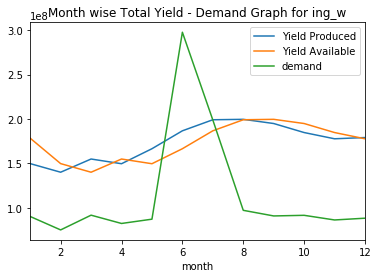

In [0]:
supply_df.merge(demand_df,left_index=True,right_index=True).plot()
plt.title('Month wise Total Yield - Demand Graph for ing_w')
plt.show()

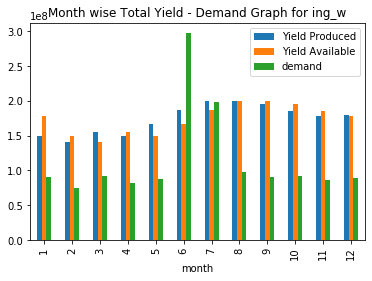

In [0]:
supply_df.merge(demand_df,left_index=True,right_index=True).plot.bar()
plt.title('Month wise Total Yield - Demand Graph for ing_w')
plt.show()

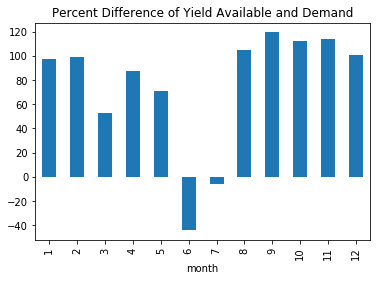

In [0]:
sup_dem_df['Excess % of Yield Available'].plot.bar()
plt.title('Percent Difference of Yield Available and Demand')
plt.show()

In [0]:
final_merged_df_viz.head(2)

date     farm_id ingredient_type       id  farming_company  \
0 2017-01-01 00:00:00  fid_100053           ing_w  8412446  Del Monte Foods   
1 2017-01-01 01:00:00  fid_100053           ing_w  8412720  Del Monte Foods   

  deidentified_location    farm_area  temp_obs  cloudiness  wind_direction  \
0         location 5290  2043.865967  8.898438         8.0           190.0   
1         location 5290  2043.865967  8.296875         8.0           210.0   

   dew_temp  pressure_sea_level  precipitation  wind_speed  day  month  hour  
0 -5.601562              1015.5           -1.0    8.203125    1      1     0  
1 -4.398438              1015.0           -1.0    8.796875    1      1     1

In [0]:
final_merged_df_viz.shape

(20848800, 18)

In [0]:
y_test_pred.shape

(20848800,)

In [0]:
final_merged_df_viz['yield']=y_test_pred

###Viewing the MONTH wise trend of the total PREDICTED yield in all the 16 deidentified locations for each particular ingredient 

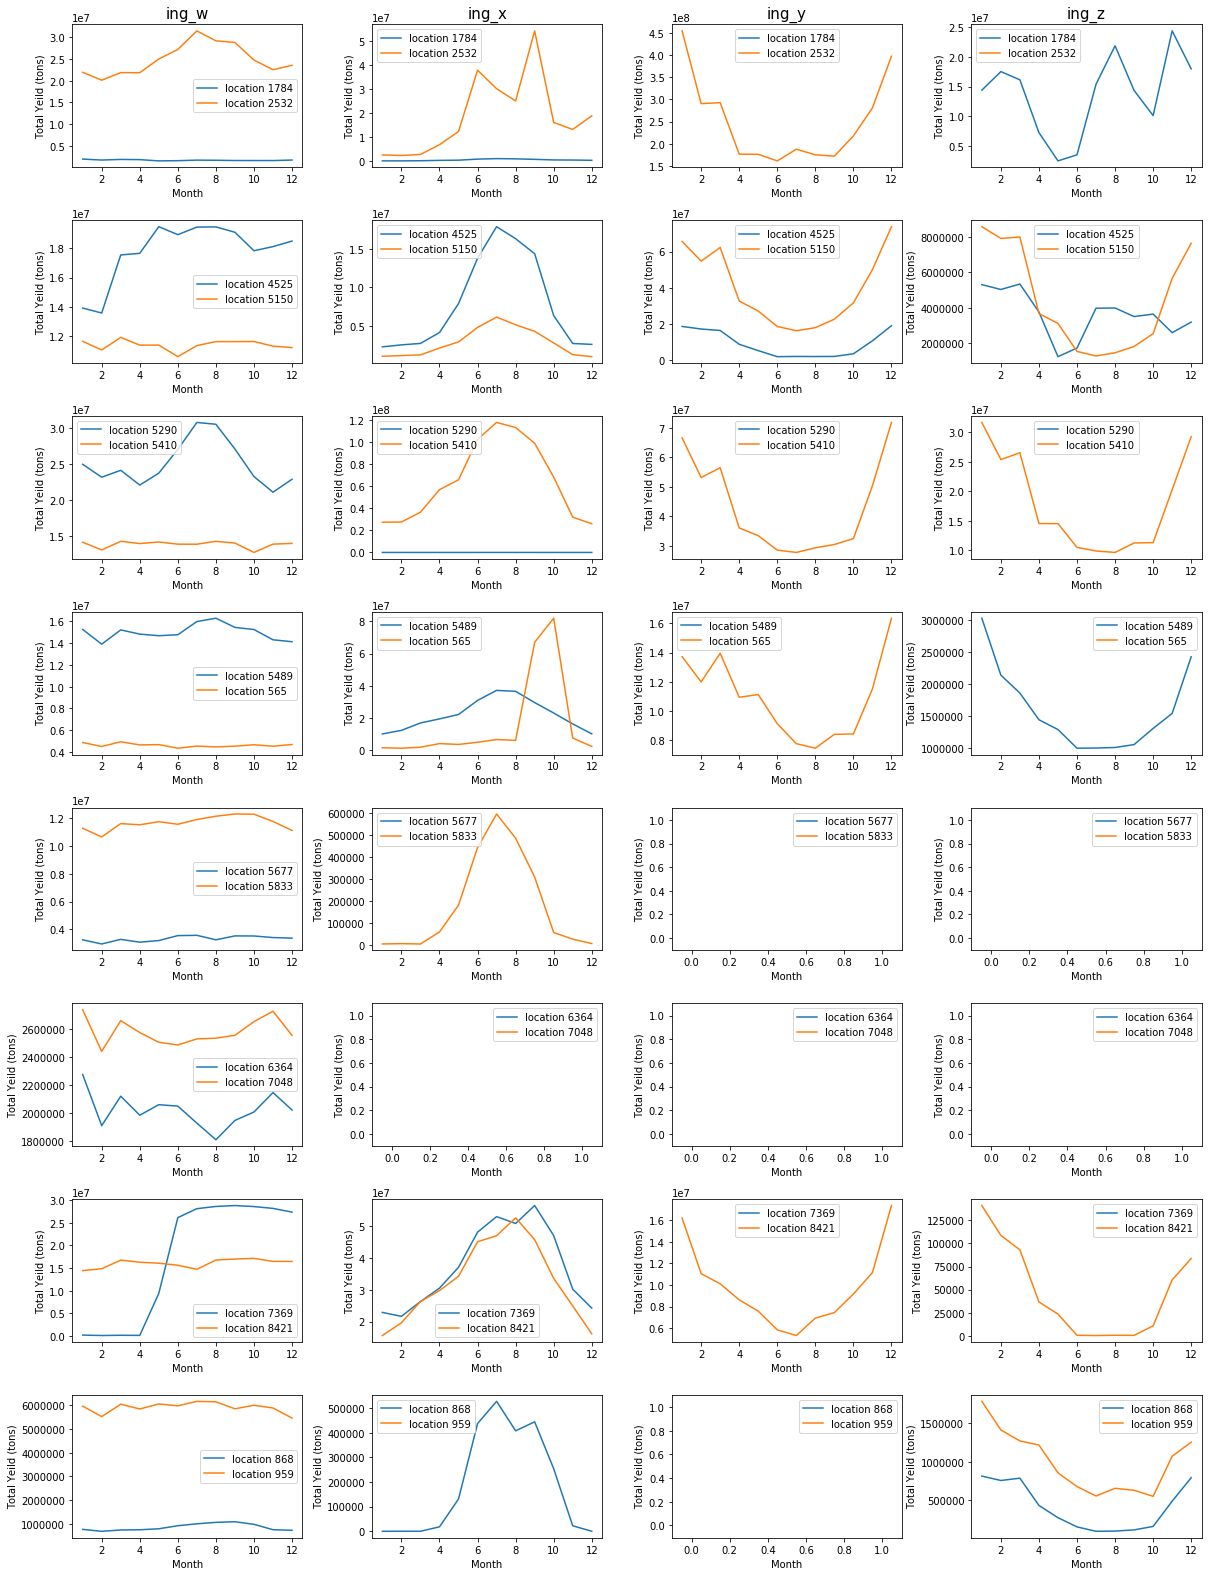

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(17,22))
for ing_idx,ing in enumerate(['ing_w','ing_x','ing_y','ing_z']):
    temp_dff=pd.DataFrame(final_merged_df_viz[final_merged_df_viz['ingredient_type']==ing]).\
            groupby(['deidentified_location','month'])['yield'].sum().unstack().T
    temp_dff.columns=[str(x) for x in list(temp_dff.columns)]
    temp_dff=my_reset_index(temp_dff)

    fig.tight_layout()
    count=0
    axes[count][ing_idx].set_title(ing,fontsize=15)
    for idx,col in enumerate(temp_dff.columns[1:]):
        
        axes[count][ing_idx].plot('month',col,data=temp_dff)
    
        show='n'
        if (idx+1)%2==0:
            
            axes[count][ing_idx].legend()
            show='y'
            axes[count][ing_idx].set_xlabel('Month')
            axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
        
            count+=1
    if show=='n':
        
        axes[count][ing_idx].legend()
        axes[count][ing_idx].set_xlabel('Month')
        axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
    


###Viewing the MONTH wise trend of the total PREDICTED yield in all the 16 farming locations for each particular ingredient 

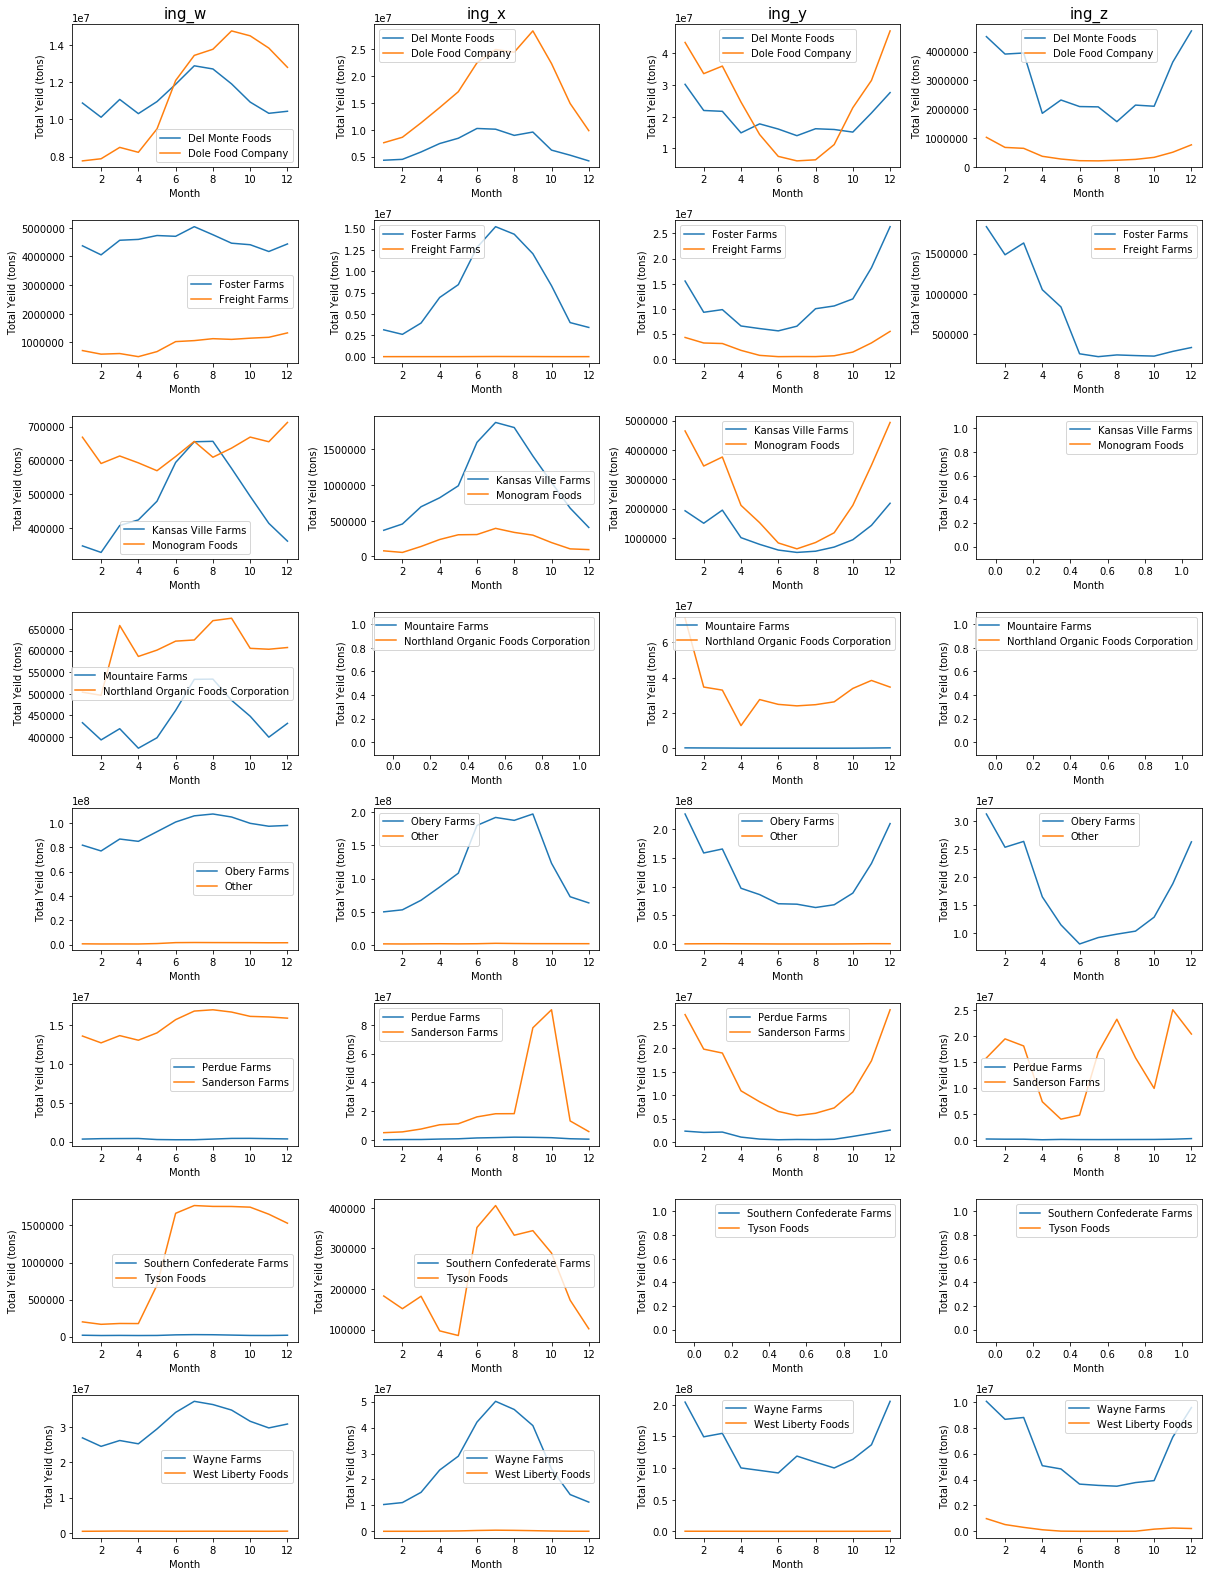

In [0]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(17,22))
for ing_idx,ing in enumerate(['ing_w','ing_x','ing_y','ing_z']):
    temp_dff=pd.DataFrame(final_merged_df_viz[final_merged_df_viz['ingredient_type']==ing]).\
            groupby(['farming_company','month'])['yield'].sum().unstack().T
    temp_dff.columns=[str(x) for x in list(temp_dff.columns)]
    temp_dff=my_reset_index(temp_dff)

    fig.tight_layout()
    count=0
    axes[count][ing_idx].set_title(ing,fontsize=15)
    for idx,col in enumerate(temp_dff.columns[1:]):
        
        axes[count][ing_idx].plot('month',col,data=temp_dff)
    
        show='n'
        if (idx+1)%2==0:

            axes[count][ing_idx].legend()
            show='y'
            axes[count][ing_idx].set_xlabel('Month')
            axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
        
            count+=1
    if show=='n':
        axes[count][ing_idx].legend()
        axes[count][ing_idx].set_xlabel('Month')
        axes[count][ing_idx].set_ylabel('Total Yeild (tons)')
    


In [0]:
deidentified_locations

array(['location 1784', 'location 2532', 'location 4525', 'location 5150',
       'location 5290', 'location 5410', 'location 5489', 'location 565',
       'location 5677', 'location 5833', 'location 6364', 'location 7048',
       'location 7369', 'location 8421', 'location 868', 'location 959'],
      dtype=object)

In [0]:
final_merged_df_viz.head(2)

date     farm_id ingredient_type       id  farming_company  \
0 2017-01-01 00:00:00  fid_100053           ing_w  8412446  Del Monte Foods   
1 2017-01-01 01:00:00  fid_100053           ing_w  8412720  Del Monte Foods   

  deidentified_location    farm_area  temp_obs  cloudiness  wind_direction  \
0         location 5290  2043.865967  8.898438         8.0           190.0   
1         location 5290  2043.865967  8.296875         8.0           210.0   

   dew_temp  pressure_sea_level  precipitation  wind_speed  day  month  hour  \
0 -5.601562              1015.5           -1.0    8.203125    1      1     0   
1 -4.398438              1015.0           -1.0    8.796875    1      1     1   

     yield  
0  35.6225  
1  35.6225

In [0]:
final_merged_df_train.head(2)

farm_id      yield  farming_company  deidentified_location    farm_area  \
0      469  37.040001               12                      8  2043.865967   
1      469  37.119999               12                      8  2043.865967   

    temp_obs  cloudiness  wind_direction  dew_temp  pressure_sea_level  \
0  10.000000         8.0           350.0  2.199219              1021.0   
1   9.398438         8.0           350.0  2.800781              1021.5   

   precipitation  wind_speed  day  month  hour  ingredient_type_ing_x  \
0            0.0    4.101562    1      1     0                      0   
1            0.0    6.199219    1      1     1                      0   

   ingredient_type_ing_y  ingredient_type_ing_z  
0                      0                      0  
1                      0                      0

###Viewing the MONTH wise trend of the total PREDICTED TEST yield and total TRAIN dataset yield in all the 16 farming locations for ingredient "ing_w"

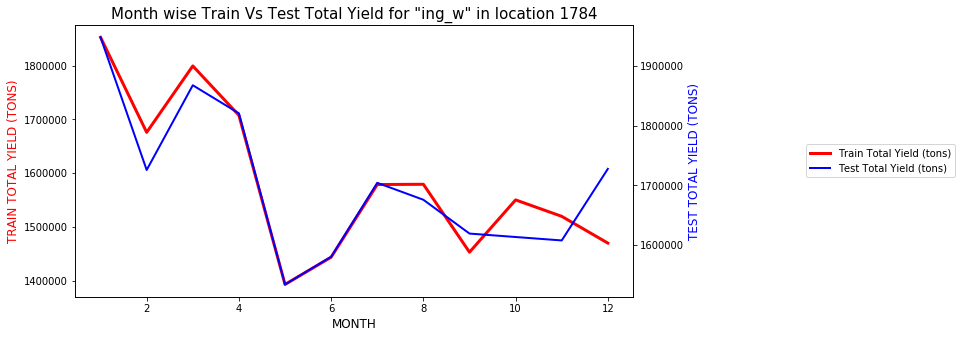

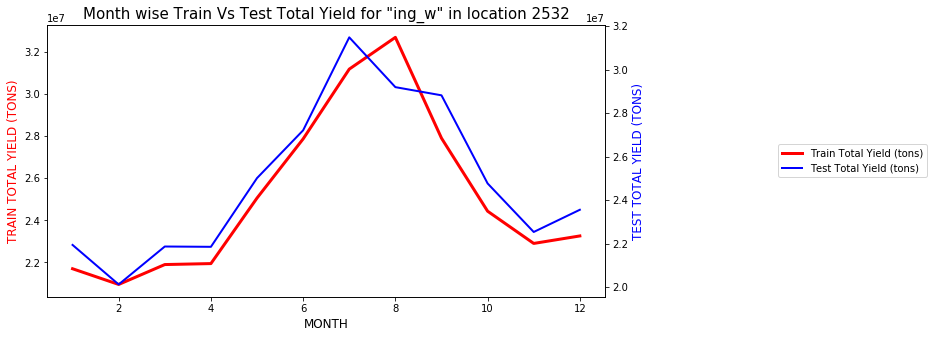

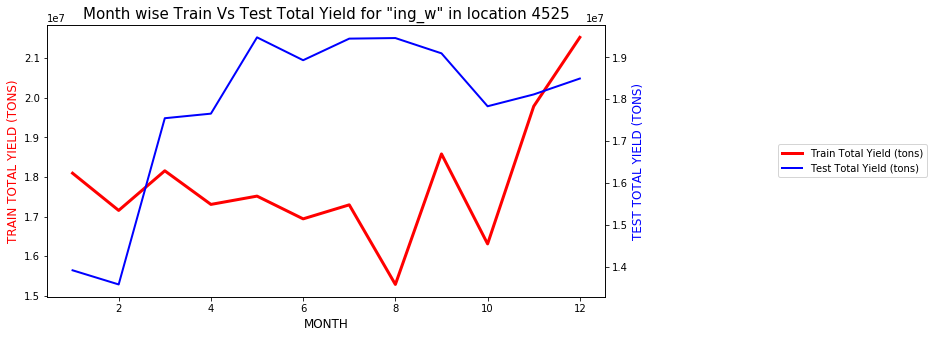

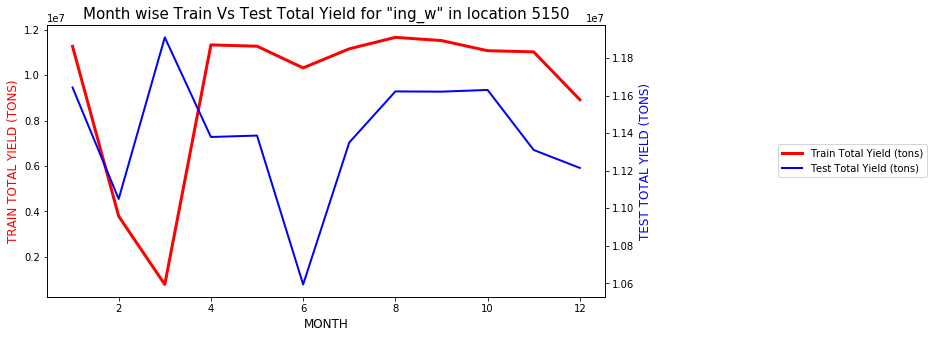

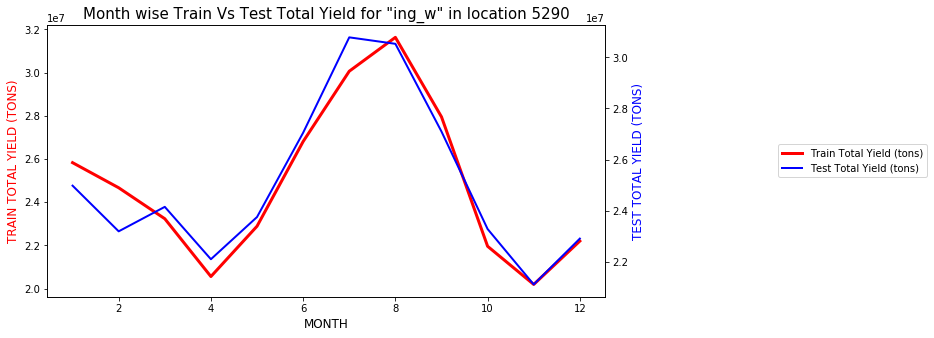

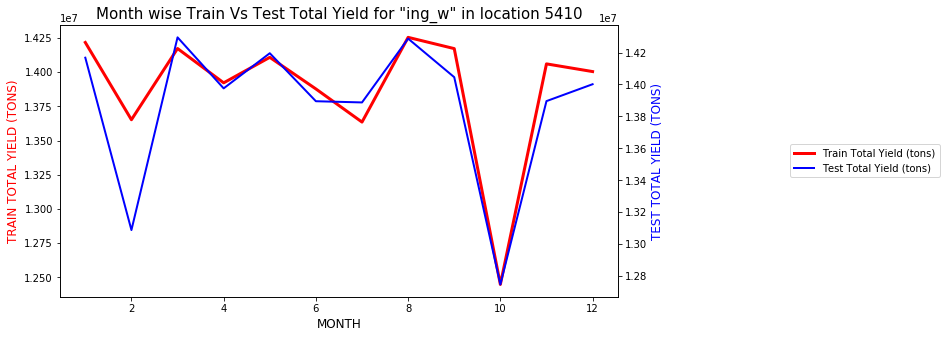

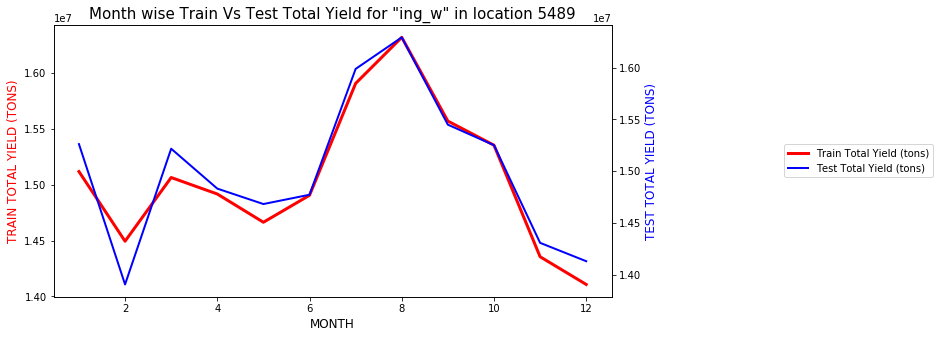

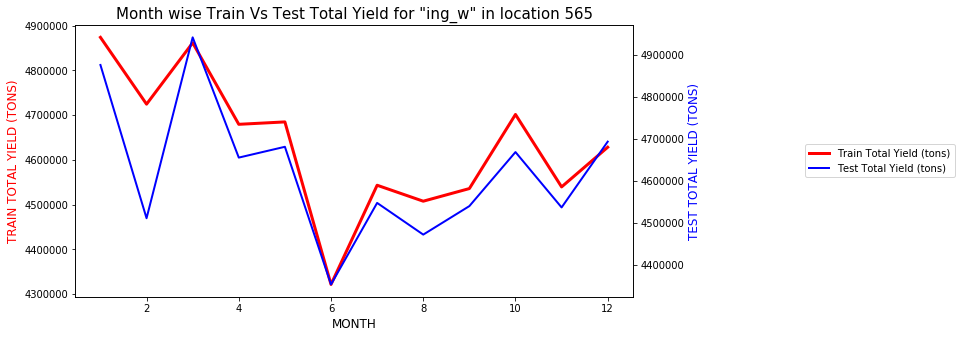

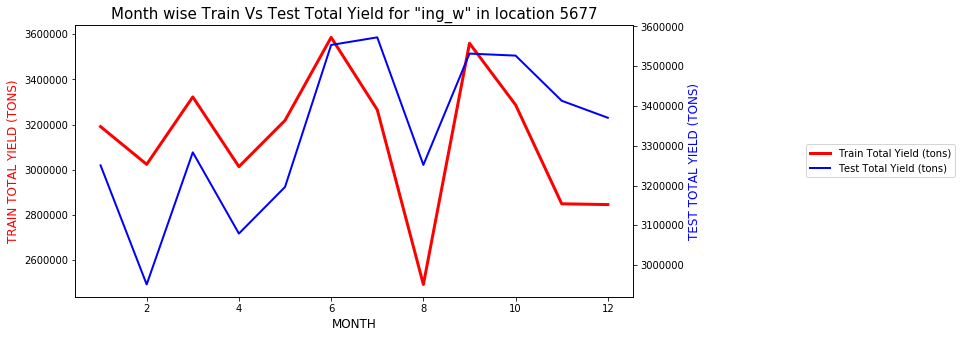

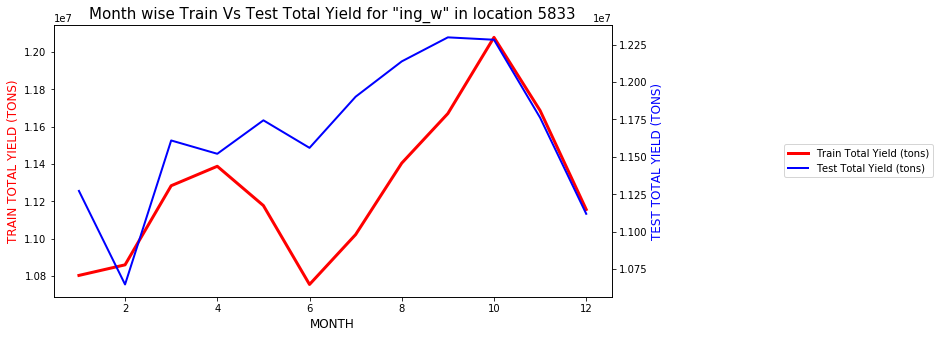

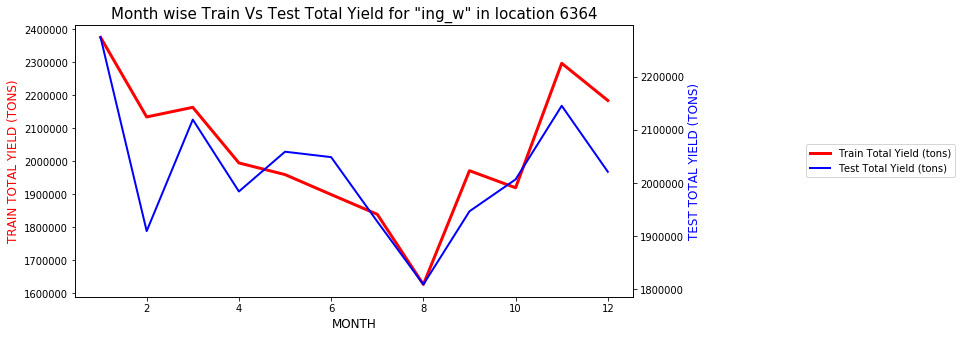

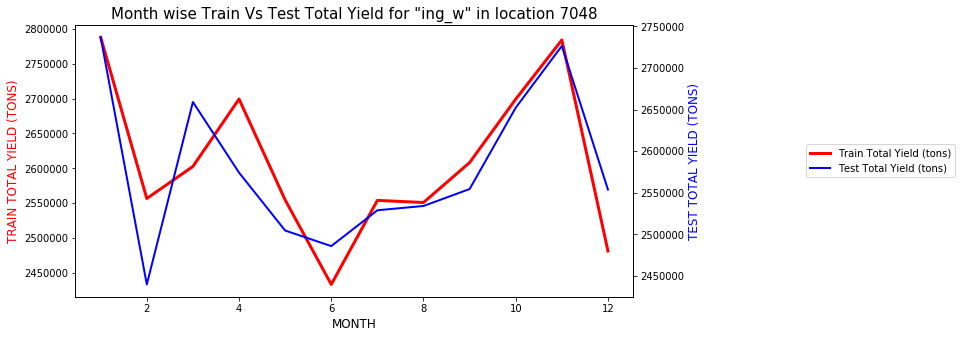

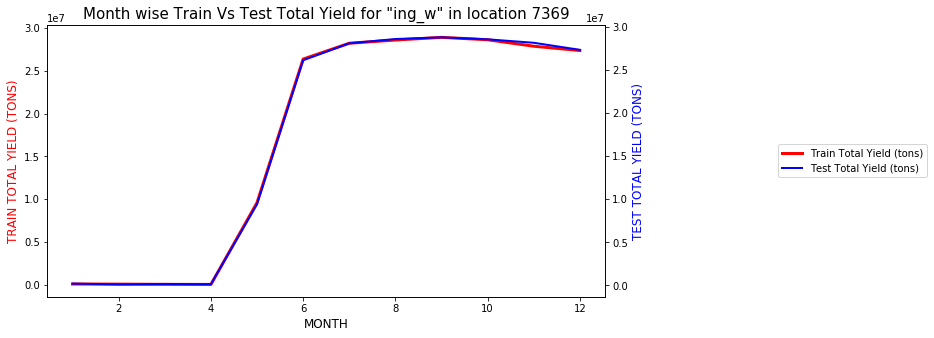

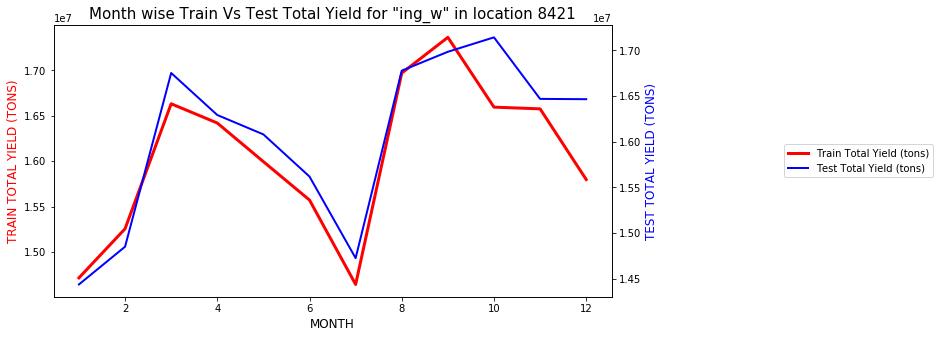

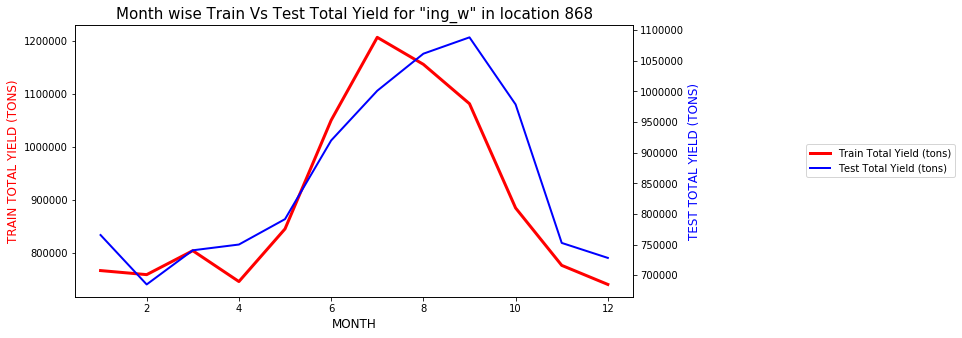

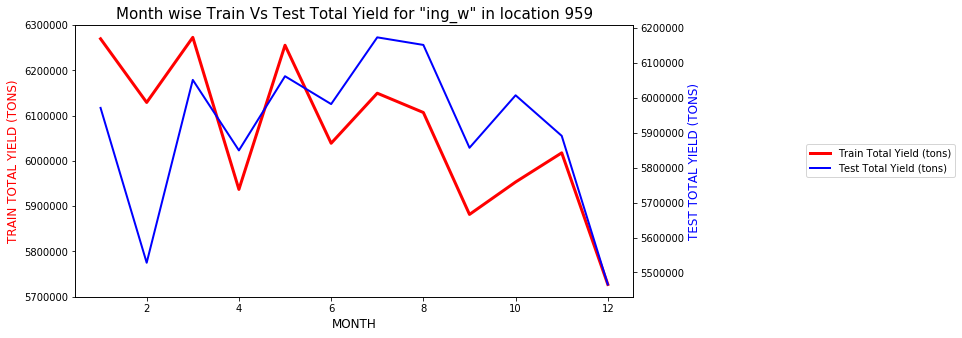

In [0]:
import matplotlib.pyplot as plt 
months=np.unique(final_merged_df['month'])

for loc in deidentified_locations:

  fig = plt.figure(figsize=(10,5))
  host = fig.add_subplot(111)

  par1 = host.twinx()
  

  host.set_xlabel(str.upper("MONTH"),fontsize=12)
  host.set_ylabel(str.upper("Train Total Yield (tons)"),fontsize=12)
  par1.set_ylabel(str.upper("Test Total Yield (tons)"),fontsize=12)
  
  yield1=pd.DataFrame(final_merged_df_train[(final_merged_df_train['deidentified_location']==deid_list_oe_dict[loc])&\
                                            (final_merged_df_train['ingredient_type_ing_x']==0)&(final_merged_df_train['ingredient_type_ing_y']==0)&\
                                            (final_merged_df_train['ingredient_type_ing_z']==0)].groupby(['month'])['yield'].sum())
                     
  yield2=pd.DataFrame(final_merged_df_viz[(final_merged_df_viz['deidentified_location']==loc)&(final_merged_df_viz['ingredient_type']=='ing_w')].\
                     groupby(['month'])['yield'].sum())
  


  p1, = host.plot(months,yield1,color='r',label="Train Total Yield (tons)",linewidth=3)
  p2, = par1.plot(months,yield2,color='b',label="Test Total Yield (tons)",linewidth=2)
  

  lns = [p1, p2]
  host.legend(handles=lns, loc='center left',bbox_to_anchor=(1.3, 0.5))

  
  
  host.yaxis.label.set_color(p1.get_color())
  par1.yaxis.label.set_color(p2.get_color())
  
  

  plt.title('Month wise Train Vs Test Total Yield for "ing_w" in '+loc,fontsize=15)
  plt.show()
 

In [0]:
output = pd.DataFrame({ 'id' : final_merged_df['id'], 'yield': y_test_pred })


In [0]:
output.dtypes

In [0]:
print('\nuint16  max=',np.iinfo(np.uint16).max,'\nuint16  min=',np.iinfo(np.uint16).min)

In [0]:
output['yield']=output['yield'].astype(np.float32)
output['id']=output['id'].astype(np.uint32)

In [0]:
np.max(output['yield'])

439656.0

In [0]:
output.dtypes

id        uint32
yield    float32
dtype: object

In [0]:
output.head()

In [0]:
output=output.sort_values(['id'])


In [0]:
output.shape

(20848800, 2)

In [0]:
output.to_csv('submission.csv', index=False)